In [1]:
import pandas as pd
import numpy as np
#surpress divide warnings
np.errstate(invalid='ignore', divide='ignore')
import matplotlib.pyplot as plt
import pickle
from src.data_tools.get_data import get_data

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.plotting_tools.draw_stack_plot_hists import draw_bckground, draw_signals, draw_data, draw_stackplot
from src.plotting_tools.SysHist import SysHist
from src.plotting_tools.Bins import Bins, bins
from src.plotting_tools.utils import ratio_plot_template
from src.data_tools.StackPlotter import get_stack_plotter
from src.plotting_tools.latexAssets import mll
from src.assets.output_dir import output_dir
output_dir

'/eos/cms/store/group/phys_exotica/bffZprime/assets_june_23'

In [5]:
split_bins = bins

In [6]:
from src.general.array_utils import moving_average, moving_sum, super_sample, super_sample_function, moving_avg_func, unp_array_to_nom_std
from src.plotting_tools.cms_format import cms_style, cms_format_fig

In [7]:
from scipy.optimize import curve_fit
from src.general.functions import power_func, power_law, make_bpoly, linear, parabola, make_bpoly_exp

/cvmfs/cms.cern.ch/slc7_amd64_gcc900/external/py3-scipy/1.7.1-c59502069094870046fda47cb5a5065e/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [8]:
from scipy.optimize import curve_fit
from src.general.functions import make_bpoly, lognorm, log_norm_np, log_norm_unp
from src.plotting_tools.SysHist import SysHist
import uncertainties
import uncertainties.unumpy as unp

In [9]:
cms_style()

In [99]:
#output_dir = 'assets_feb_23'
outdir = '{}/abcd_LCR_to_SR'.format(output_dir)
era = '2016'
ismc=1
isdata = ismc==0

In [100]:
sp = get_stack_plotter(output_dir, era, bins='none')

In [101]:
def compare_hists(fhist, dhist, ismc_pull = False, n=10, ndof=0, log=1, color='red', flabel="", dlabel="", 
                  dhist_isdata=0, fhist_is_data=0, ratio=False,  isabcd=0, **kwargs):
    fig, ax, rax = ratio_plot_template(figsize=(10,10))
    
    
    fhist.draw(ax, label=flabel, zorder=3)
    if dhist_isdata:
        ax.errorbar(dhist.calc_bin_centers(), dhist.nominal, yerr=dhist.std, color='black', label=dlabel,
           ls='', marker='o', zorder=3)
    else:
        dhist.draw(ax, label=dlabel, zorder=1, color=color, errorbar=False, draw_sys=0)#, sys_label='Background Systematics')
    
    x = fhist.calc_bin_centers()
    if isdata:
        cms_format_fig(era, ax, "\emph{Preliminary}")
    else:
        cms_format_fig(era, ax, "\emph{Simulation}")
    if log:
        ax.set_yscale('Log')
    ax.set_ylabel('Counts per GeV')
    
    #calc pull
    nom1_avg = moving_sum(fhist.nominal, n = n)
    nom2_avg = moving_sum(dhist.nominal, n = n)
    var1_avg = moving_sum(fhist.std**2, n = n)
    var2_avg = moving_sum(dhist.std**2, n = n)
    x_avg = moving_average(x, n=n)
    if ismc_pull:
        pull = (nom1_avg-nom2_avg)/(var2_avg+var1_avg)**.5
    else:
        pull = (nom1_avg-nom2_avg)/nom1_avg**.5
    pullsquare = pull**2
        
    
    if ratio:
        rax.plot(x, np.full(len(x), .5) , color='black', linestyle=':')
        rax.plot(x, np.full(len(x), 0) , color='black')
        rax.plot(x, np.full(len(x), 1.5) , color='black', linestyle=':') 
        rax.set_ylim(0,2)
        if fhist_is_data:
            rax.set_ylabel('Obs./MC')
        else:
            if isabcd: rax.set_ylabel('ABCD/MC')
            else: rax.set_ylabel('Fit/MC')
        fhist.calc_ratio(dhist.nominal).draw(rax, zorder=1)
        if dhist_isdata:
            dhist.calc_ratio(dhist.nominal).draw(rax, color=color, zorder=0)
        else:
            dhist.calc_ratio(dhist.nominal).draw(rax, color=color, zorder=0, errorbar=False)
    else:
        rax.plot(x, np.full(len(x), 1) , color='black', linestyle=':')
        rax.plot(x, np.full(len(x), 0) , color='black')
        rax.plot(x, np.full(len(x), -1) , color='black', linestyle=':')
        rax.set_ylim(-5,5)
        rax.set_ylabel('Pull')
        rax.plot(x_avg, pull)
        
    rax.set_xlabel('{} [GeV]'.format(mll))
    return  {'chi2': (pullsquare).sum()/(fhist.calc_nBins()-ndof),
             'fig': fig,
             'ax': ax,
             'rax': rax}
    

In [102]:
def fit_hist(func, hist, n=10, comp_hist_n =10, do_super_sample=1, ismc=False,  do_unc=1, color='red', 
             flabel="", dlabel="", dhist_isdata=0, fhist_is_data=0, **kwargs):
    x = np.array(hist.calc_bin_centers())
    if not isdata:
        popt, pcov = curve_fit(func, x, hist.nominal, 
                       **kwargs,
                       sigma=hist.std, maxfev = int(1e6))  
    else:
        #std is not optimal for data: zero and low count bins will be subotimal error estimates
        popt, pcov = curve_fit(func, x, hist.nominal, 
               **kwargs, maxfev = int(1e6))  
    if do_unc:
        #create fit values with uncertainties
        popt_unc = uncertainties.correlated_values(popt, pcov)
        #make_fit_hist
        y = log_norm_unp(x, *popt_unc)
        y_nom, y_std = unp_array_to_nom_std(y)
    else: 
        y_nom = func(x, *popt)
        varper = ((hist.nominal-y_nom)**2/y_nom).mean()
        y_std = (varper*y_nom)**.5
        y_std = y_nom**.5
    fit_hist = SysHist(
            y_nom,
            x*0, x*0, 
            y_std,
            np.array(hist.bin_edges)
        ).normalize().calc_ratio(1/hist.calc_sum())

    compare_dict = compare_hists(fit_hist, hist, ismc=ismc, n=comp_hist_n, color = color, ndof=5, flabel=flabel, dlabel=dlabel, dhist_isdata=dhist_isdata)
    
    return {**compare_dict, 
            "popt" : np.array(popt),
            "pcov": np.array(pcov),
            "fit_hist": fit_hist
           }

In [103]:
bottom_value = 120
top_value=400
feature='DiLepMass'
sp.x_range = (bottom_value, top_value)

In [104]:
from scipy.ndimage import gaussian_filter

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


CRA
CRA 0.9451706830614888 array([1.52393272e+04, 6.83794201e-01, 5.00000000e+01, 8.90330739e+01])


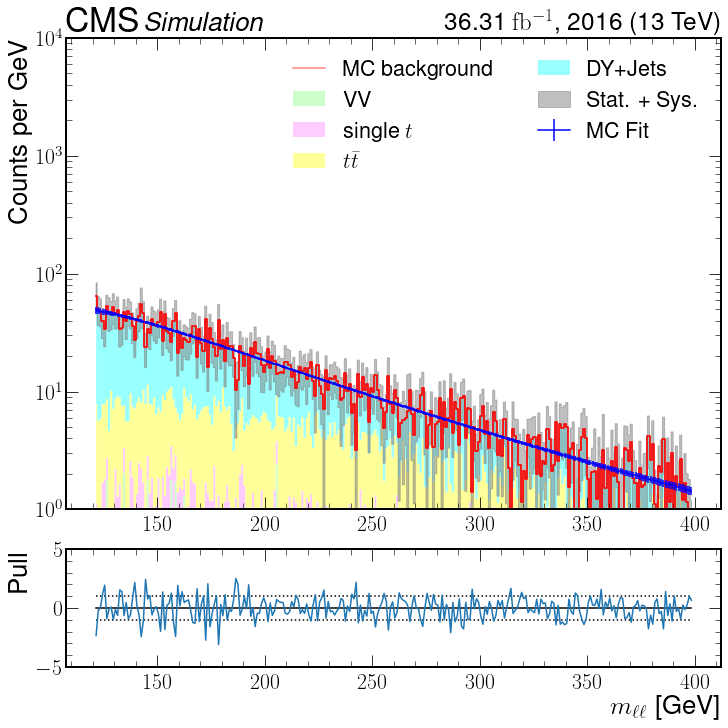

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


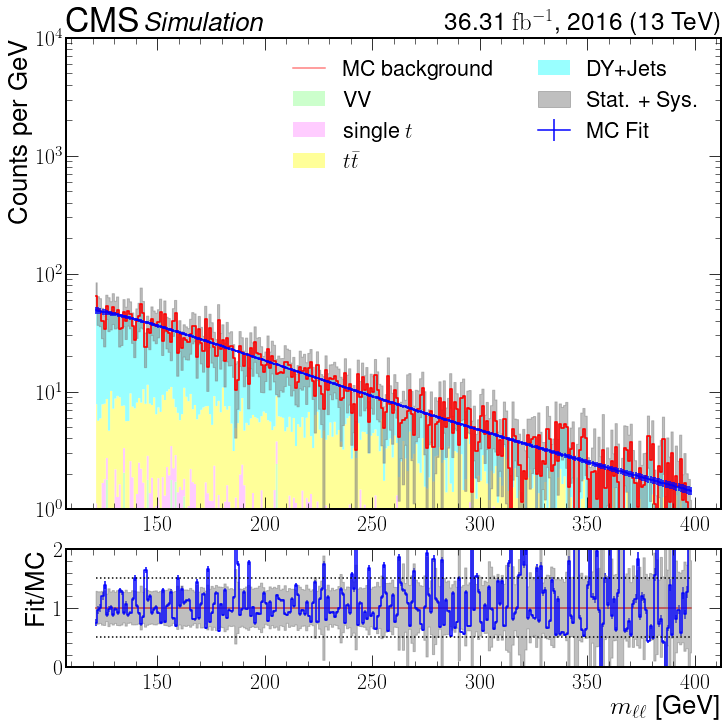

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


CRA2
CRA2 1.3611100533114764 array([7.58376217e+03, 6.65662739e-01, 5.00011220e+01, 1.00000000e+02])


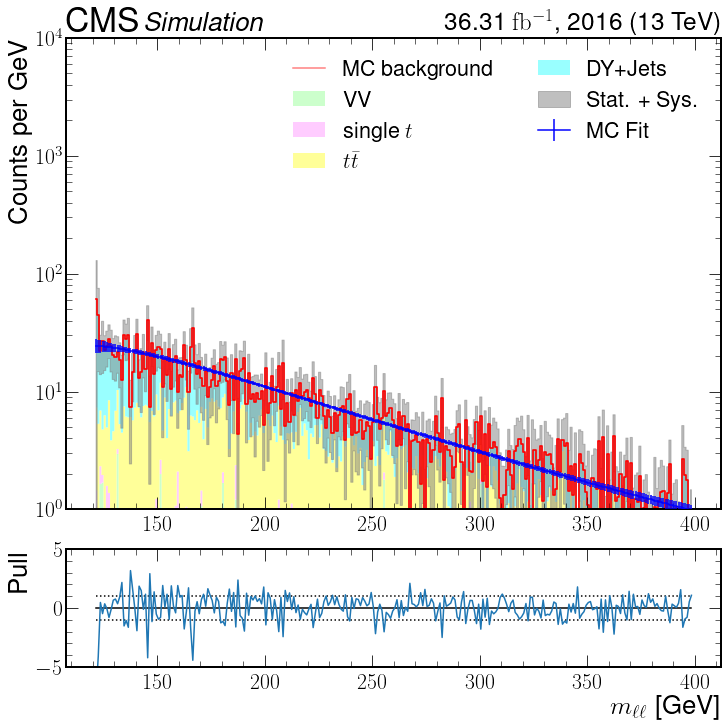

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


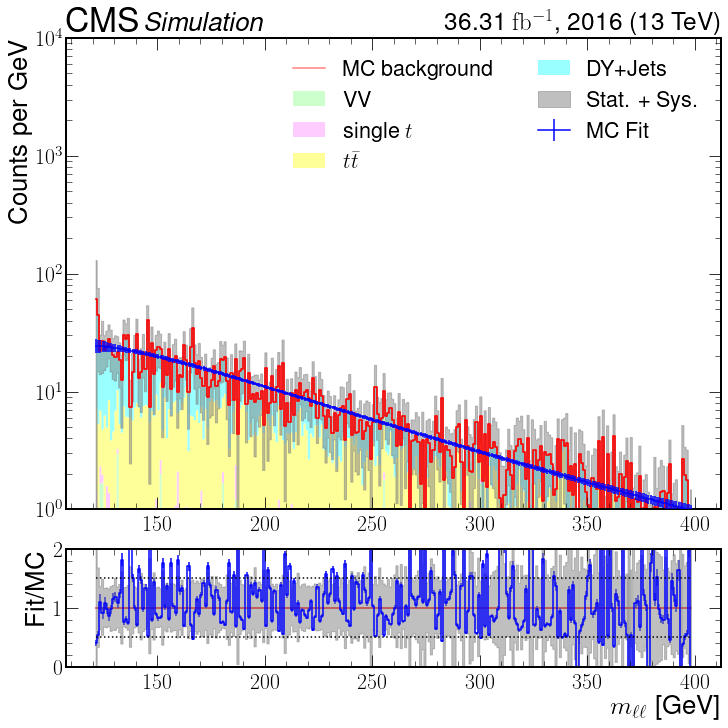

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


CRB
CRB 1.2365278528806172 array([9.75018814e+03, 6.13716117e-01, 5.00000000e+01, 9.41709516e+01])


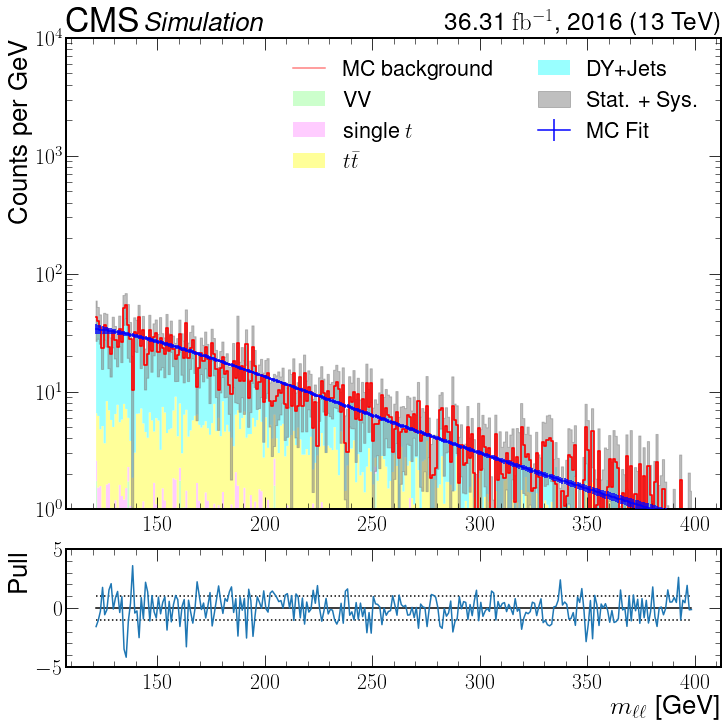

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


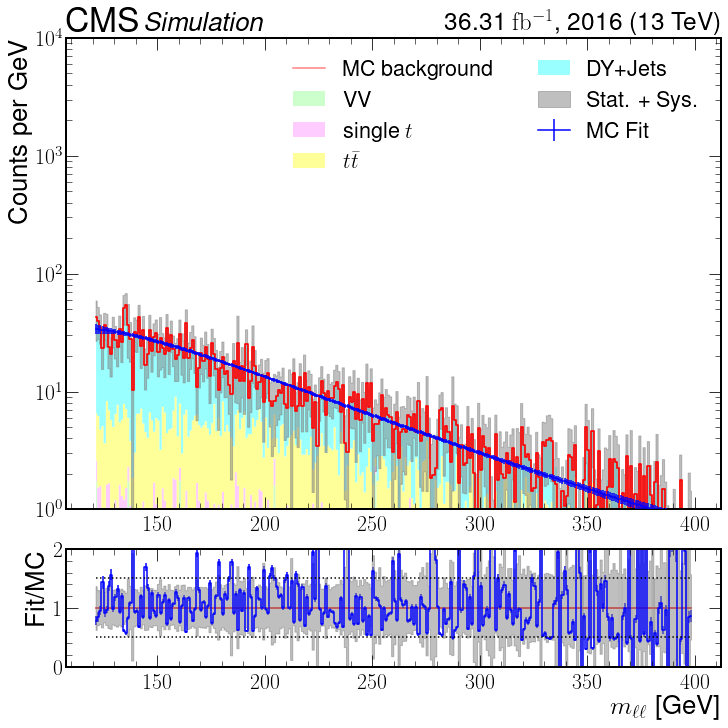

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


CRB2
CRB2 1.1125290148022542 array([4.66432626e+03, 6.16605111e-01, 5.42185719e+01, 1.00000000e+02])


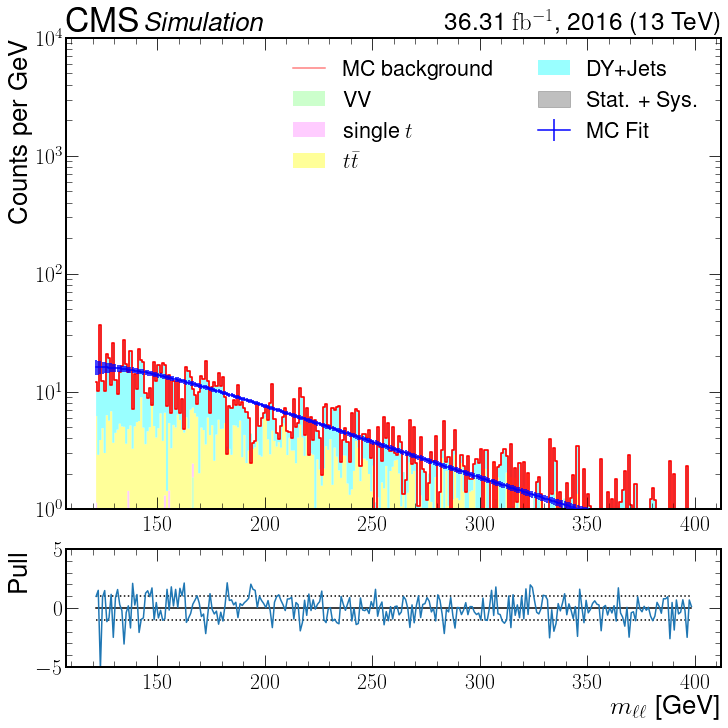

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


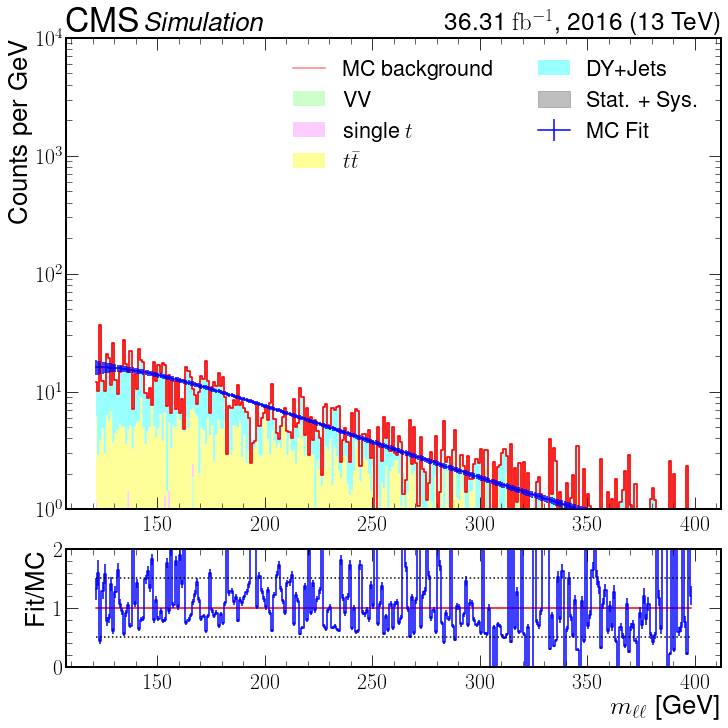

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


CRD
CRD 1.0791657438050704 array([1.02838952e+05, 7.59857850e-01, 6.21317269e+01, 7.44403910e+01])


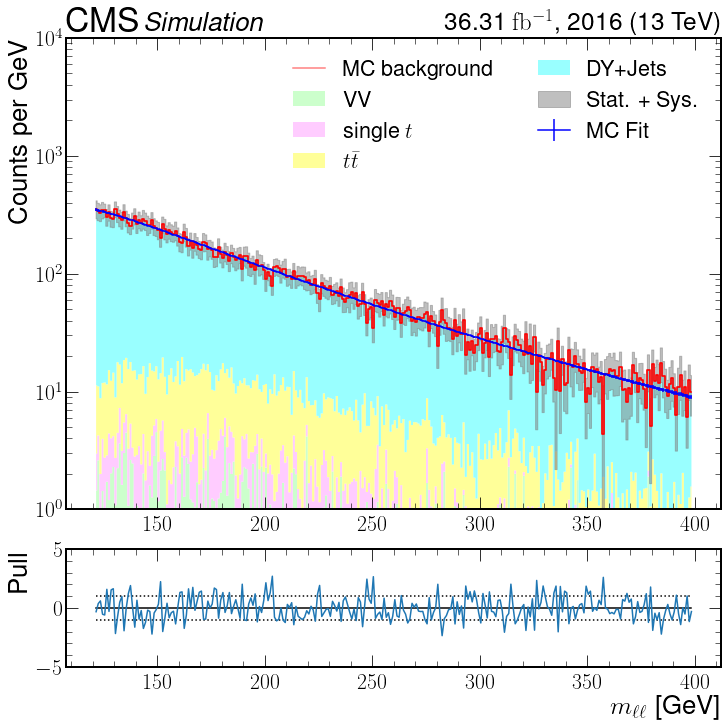

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


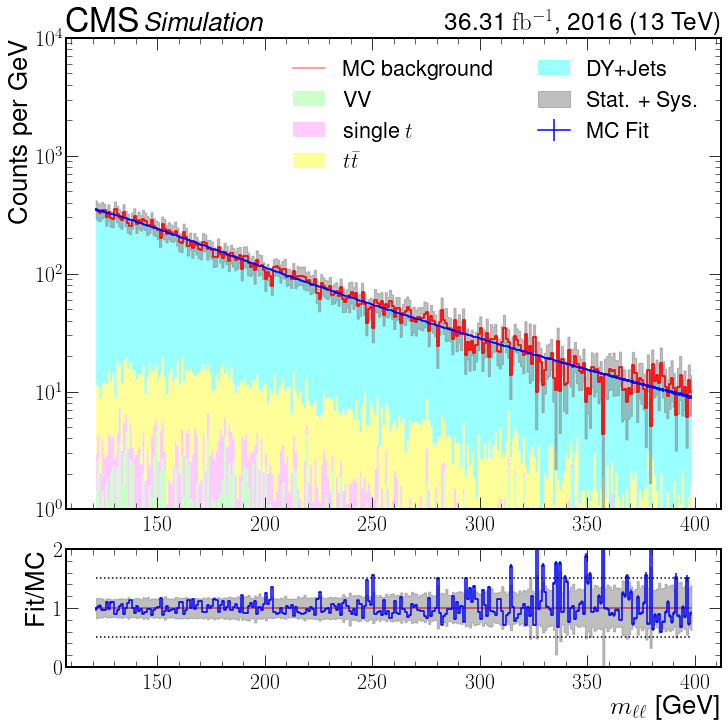

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


CRD2
CRD2 1.2308739900533032 array([2.44975034e+04, 7.98880800e-01, 5.00000000e+01, 7.87612143e+01])


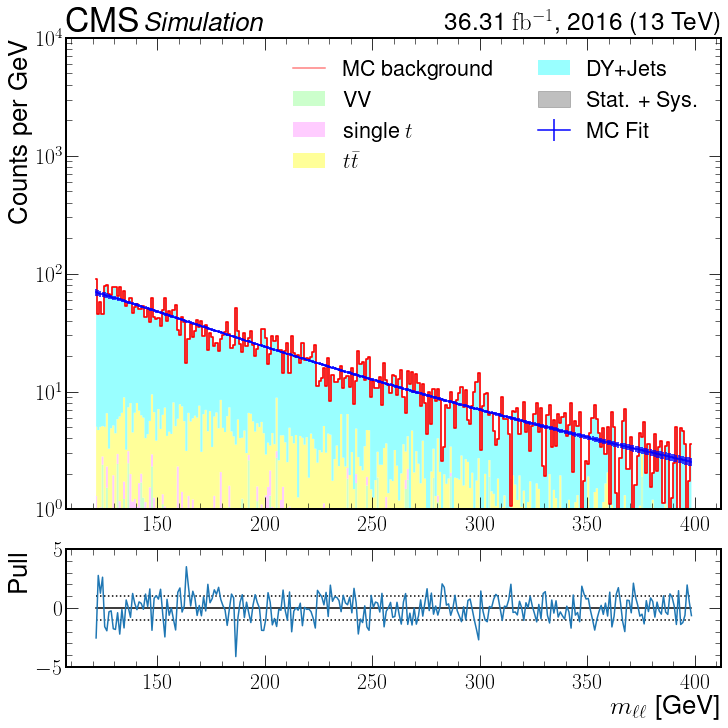

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


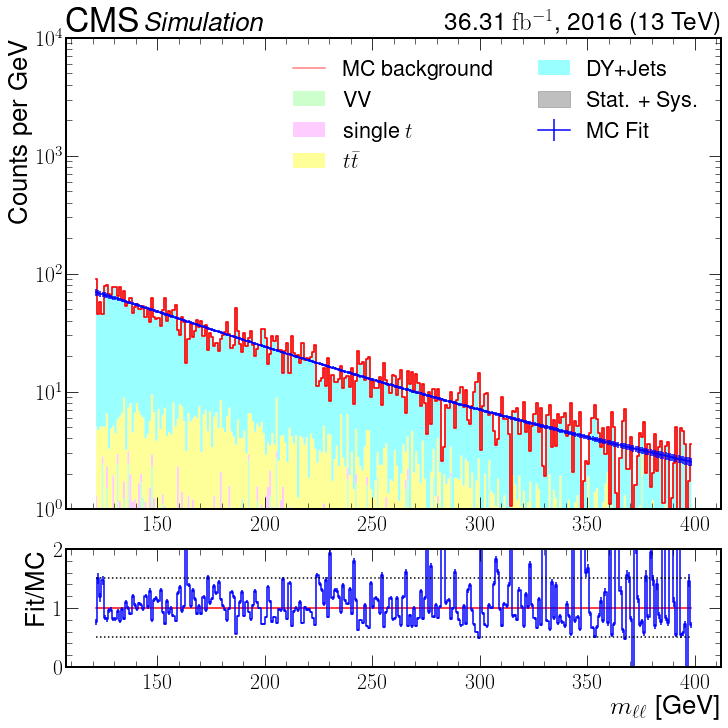

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


CRC
CRC 1.385809537266531 array([5.56939866e+04, 8.20724108e-01, 8.82343386e+01, 6.67725111e+01])


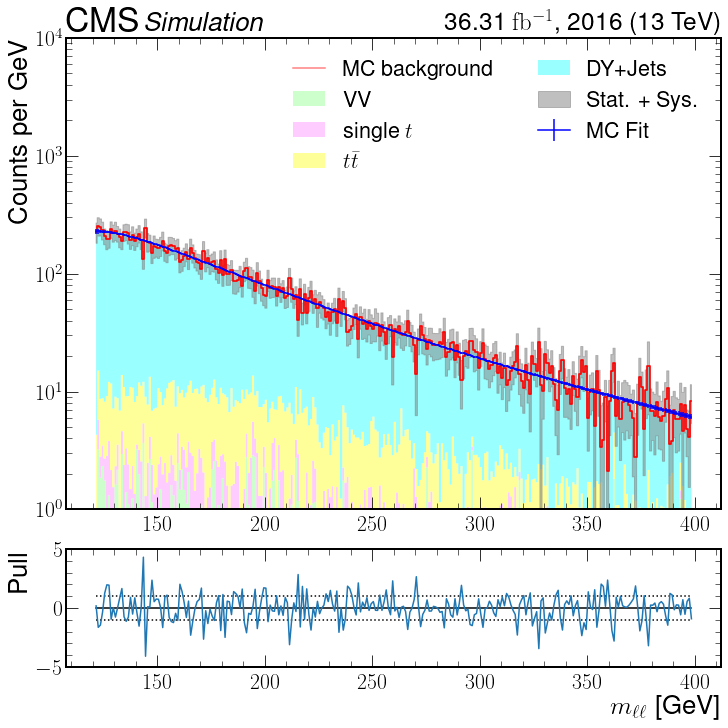

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


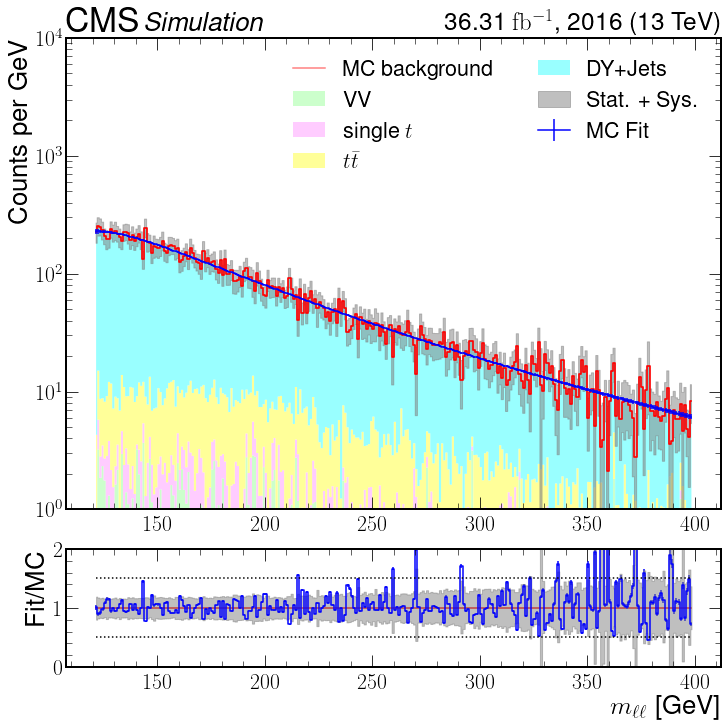

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


CRC2
CRC2 1.5108486594914714 array([1.53251784e+04, 7.14857369e-01, 5.00000000e+01, 8.60645228e+01])


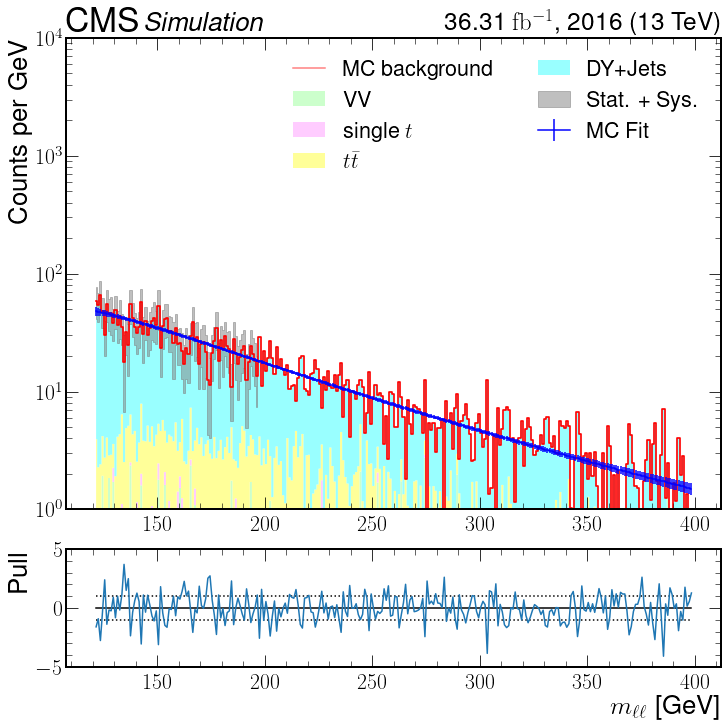

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


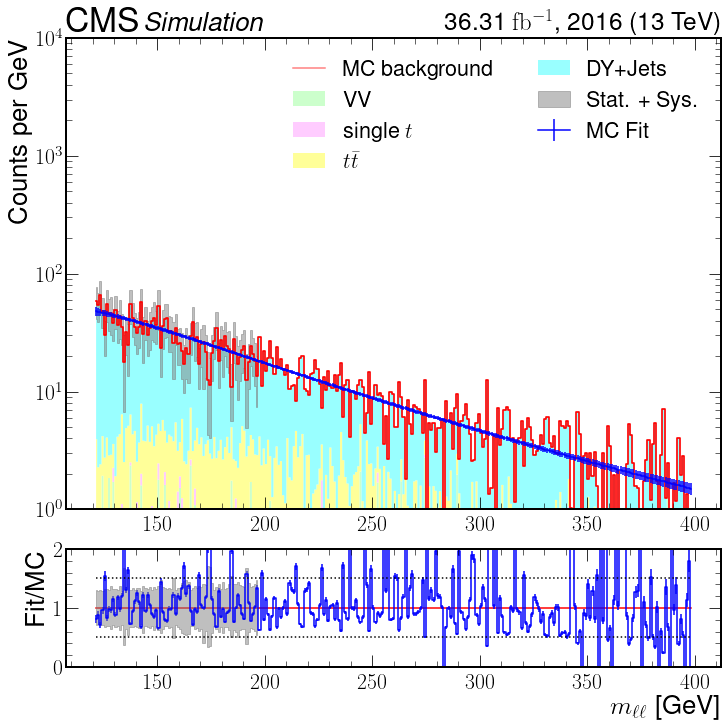

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


CR13
CR13 0.6740520058377372 array([8.15768477e+03, 5.75184554e-01, 6.20375523e+01, 1.00000000e+02])


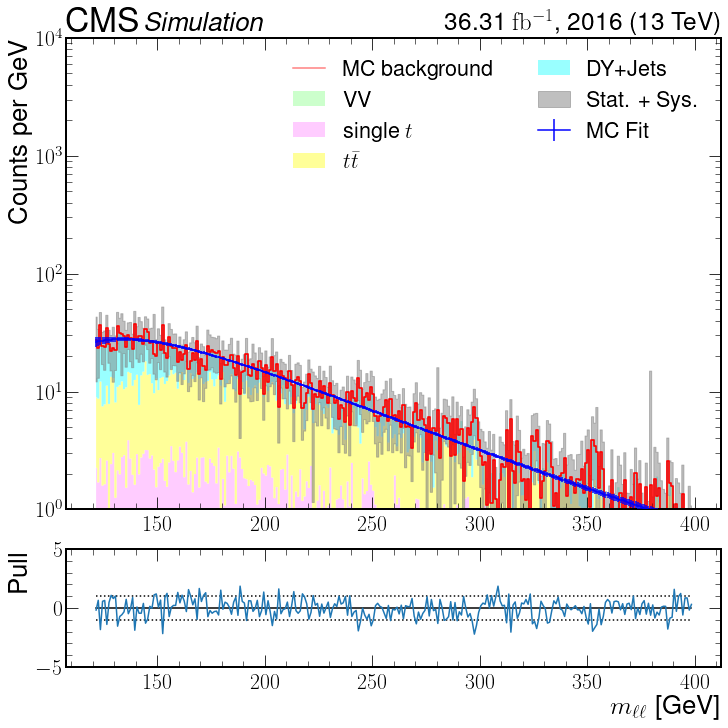

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


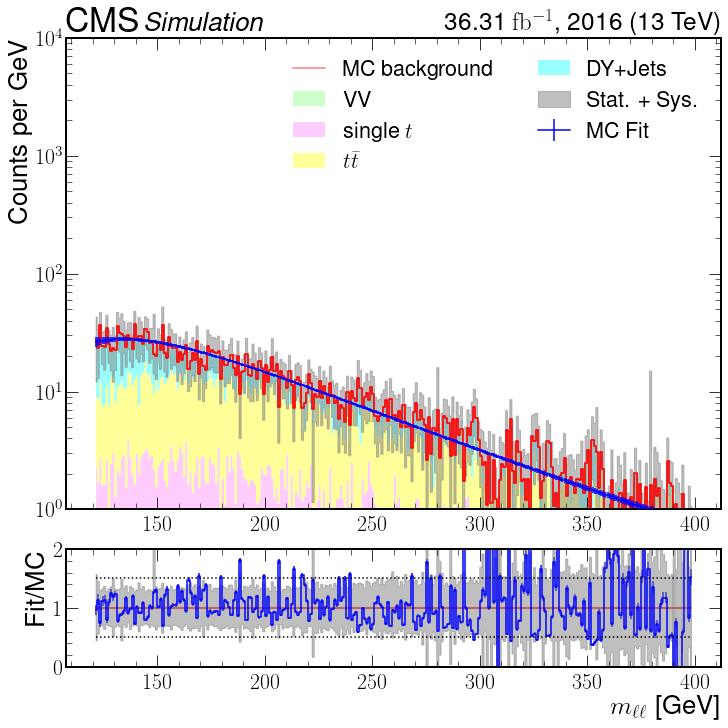

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


CR23
CR23 1.0148100358427499 array([5.51002713e+03, 5.60705815e-01, 7.78465975e+01, 1.00000000e+02])


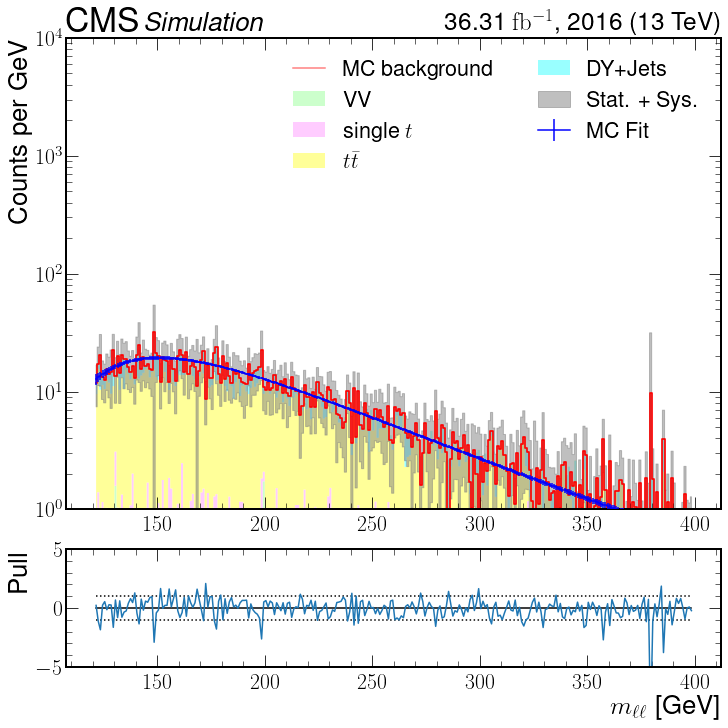

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


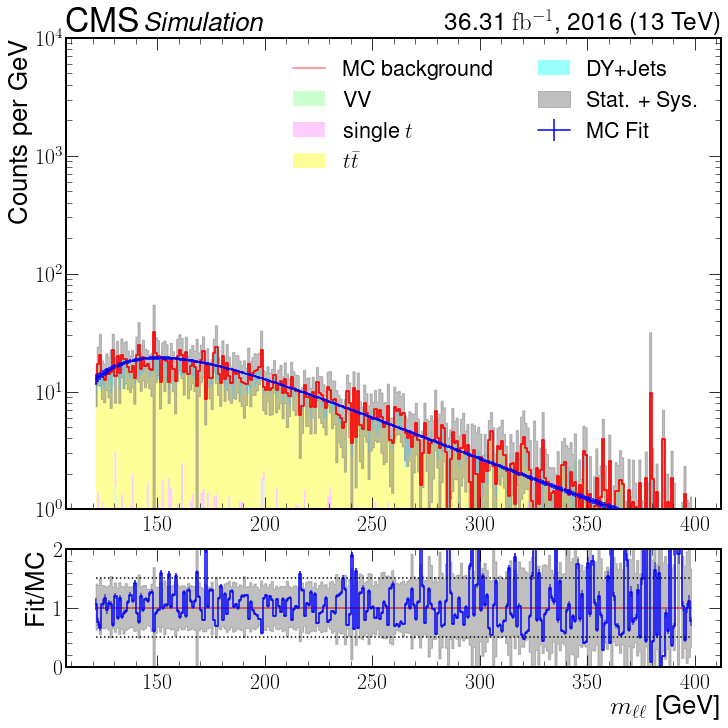

In [105]:
comp_hist_n = 1
sp.rebin = 0
fit_dict = {}
for reg in ['CRA','CRA2', 'CRB', 'CRB2', 'CRD', 'CRD2', 'CRC', 'CRC2', 'CR13', 'CR23']:
    #data for fitting, data or MC?
    if isdata:
        _plot_dict = sp.make_data_hist(feature, reg)
    else:
        _plot_dict = sp.combine_back(feature, reg)
    #reduce the range for fitting
    hist = _plot_dict.reduce_range(bottom=bottom_value, top=top_value)
    if ismc: hist.std += gaussian_filter(hist.std,2)
    #hist.up *=0
    #hist.down *=0
    total_events = hist.nominal.sum()
    #fit the hist
    flabel='Observed Fit' if isdata else 'MC Fit'
    dlabel = 'Observed' if isdata else None
    # fit and pull plot
    
    
    curve_fit_chi2 = fit_hist(log_norm_np, hist, comp_hist_n=comp_hist_n, do_super_sample=0, 
                              ismc=ismc, p0=[total_events*10, .8, 80, 70], 
                              bounds = ([0, .2, 50, 50], [total_events*100, 1, 100, 100]),
                              do_unc=1, flabel=flabel, dlabel=dlabel, dhist_isdata=isdata,fhist_is_data=isdata,
                             )
    
    
    sp.draw_background(curve_fit_chi2['ax'], feature, reg, sys_label='Stat. + Sys.', errorbar=False)
    print(reg)
    fit_dict[reg] = curve_fit_chi2
    print(reg, curve_fit_chi2['chi2'],  repr(curve_fit_chi2['popt']))
    # reorder legend
    handles, labels = curve_fit_chi2['ax'].get_legend_handles_labels()
    order = [0,1,2,3,4,5,7,6]
    if ismc: order = np.linspace(0,len(handles)-1, len(handles), dtype=int)
    curve_fit_chi2['ax'].legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
                                ncol=2)
    curve_fit_chi2['ax'].set_ylim(bottom=1e0, top=1e4)
    curve_fit_chi2['fig'].savefig('{}/fit_data_pull_era{}_ismc{}_reg{}_bottom{}_lognorm.pdf'.format(outdir,era,ismc,reg,bottom_value))
    plt.show()
    #200gev pull
    curve_fit_chi2['ax'].set_xlim(left=bottom_value, right=200)
    curve_fit_chi2['rax'].set_xlim(left=bottom_value, right=200)
    curve_fit_chi2['fig'].savefig('{}/fit_data_pull_era{}_ismc{}_reg{}_bottom{}_lognorm_200GeVMax.pdf'.format(outdir,era,ismc,reg,bottom_value))

    ### ratio plot
    #rebin to split binning for these plots
    sp.rebin = 0 #split_bins.bin_edges
    bhist = sp.combine_back(feature, reg).make_density_hist()
    bhist.nominal += 1e-10
    fit_hist_rebin = curve_fit_chi2['fit_hist'].reduce_range(bottom=bottom_value, top=top_value).make_density_hist()
    ratio_dict = compare_hists(fit_hist_rebin, bhist, n=comp_hist_n, 
                               color = 'red', ndof=5, flabel=flabel, ratio=True, dhist_isdata=0, fhist_is_data=isdata)
    ratio_dict['ax'].legend()
    sp.draw_background(ratio_dict['ax'], feature, reg, sys_label='Stat. + Sys.', errorbar=False)
    if isdata:
        data_plot = sp.make_data_hist(feature, reg).make_density_hist()
        ratio_dict['ax'].errorbar(data_plot.calc_bin_centers(), data_plot.nominal, yerr=data_plot.std, 
                    color='black', label='Observed', ls='', marker='o', zorder=2)
        
        ratio_dict['rax'].errorbar(data_plot.calc_bin_centers(), data_plot.nominal/bhist.nominal,
                                   yerr=data_plot.std/bhist.nominal, 
                    color='black', ls='', marker='o', zorder=.5)        
        
    handles, labels = ratio_dict['ax'].get_legend_handles_labels()
    order = [0,1,2,3,4,6,5,7]
    if ismc: order = np.linspace(0,len(handles)-1, len(handles), dtype=int)
    ratio_dict['ax'].legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
                                ncol=2)

    ratio_dict['ax'].set_ylim(bottom=1e0, top=1e4)
    ratio_dict['fig'].savefig('{}/fit_mc_ratio_era{}_ismc{}_reg{}_bottom{}_lognorm.pdf'.format(outdir,era,ismc,reg,bottom_value))
    plt.show()
    #200gev pull
    ratio_dict['ax'].set_xlim(left=bottom_value, right=200)
    ratio_dict['rax'].set_xlim(left=bottom_value, right=200)
    ratio_dict['fig'].savefig('{}/fit_mc_ratio_era{}_ismc{}_reg{}_bottom{}_lognorm_200GeVMax.pdf'.format(outdir,era,ismc,reg,bottom_value))
    sp.rebin = 0
    




In [106]:
#### abcd

In [107]:
def make_fit_hist(template_hist, reg):
    tmp_xrange = sp.x_range
    sp.x_range = (-np.inf, np.inf)
    template_hist = sp.combine_back(feature, reg)
    x = np.array(template_hist.calc_bin_centers())
    popt, pcov = fit_dict[reg]['popt'], fit_dict[reg]['pcov']
    popt_unc = uncertainties.correlated_values(popt, pcov)
    y = log_norm_unp(x, *popt_unc)
    y_nom, y_std = unp_array_to_nom_std(y)
    fit_hist = SysHist(
            y_nom,
            x*0, x*0, 
            y_std,
            np.array(template_hist.bin_edges)
        )
    sp.x_range = tmp_xrange
    return fit_hist

In [108]:
def make_abcd(nJets):
    A = make_fit_hist(bhist, 'CR{}3'.format(nJets))
    _nJets = 2 if nJets==2 else ""
    B = make_fit_hist(bhist, 'CRA{}'.format(_nJets))
    C = make_fit_hist(bhist, 'CRB{}'.format(_nJets))
    abcd = A.uncertainty_std_dev()*B.uncertainty_std_dev()/C.uncertainty_std_dev()
    print( A.uncertainty_std_dev().sum(), B.uncertainty_std_dev().sum(), C.uncertainty_std_dev().sum(), abcd.sum())
    abcd_nom, abcd_std = unp_array_to_nom_std(abcd)
    return SysHist(abcd_nom, abcd_nom*0,abcd_nom*0,abcd_std, A.bin_edges)

3023+/-19 4614+/-34 3148+/-30 (4.41+/-0.05)e+03


/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


2176+/-9 2465+/-28 1607+/-19 3300+/-29


/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


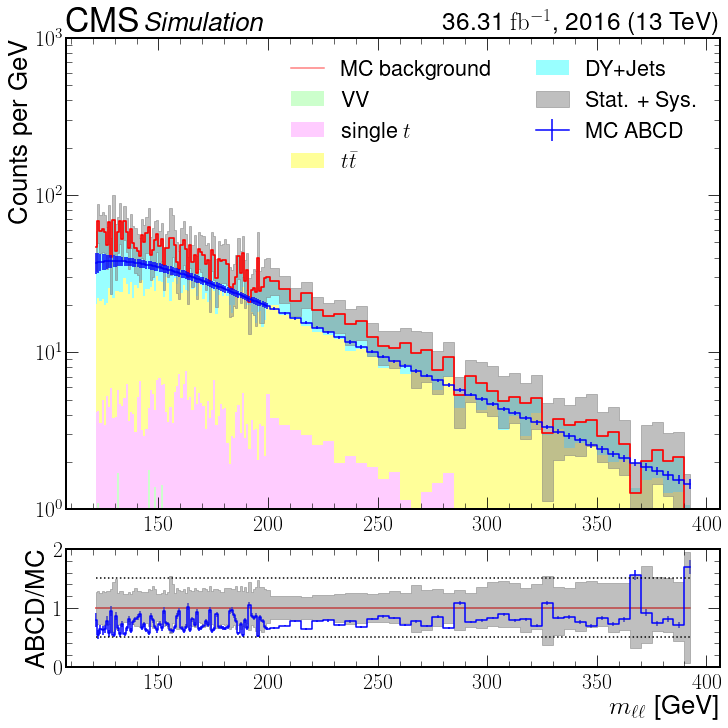

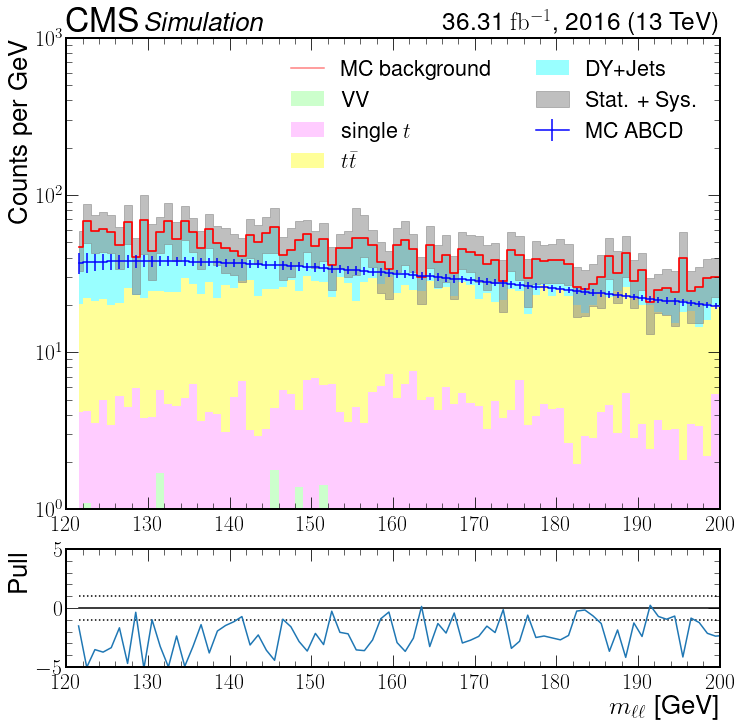

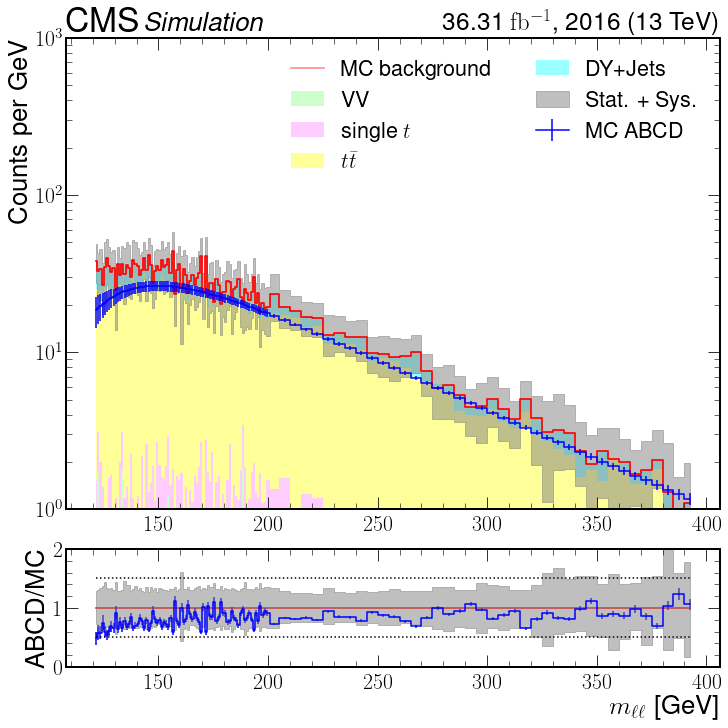

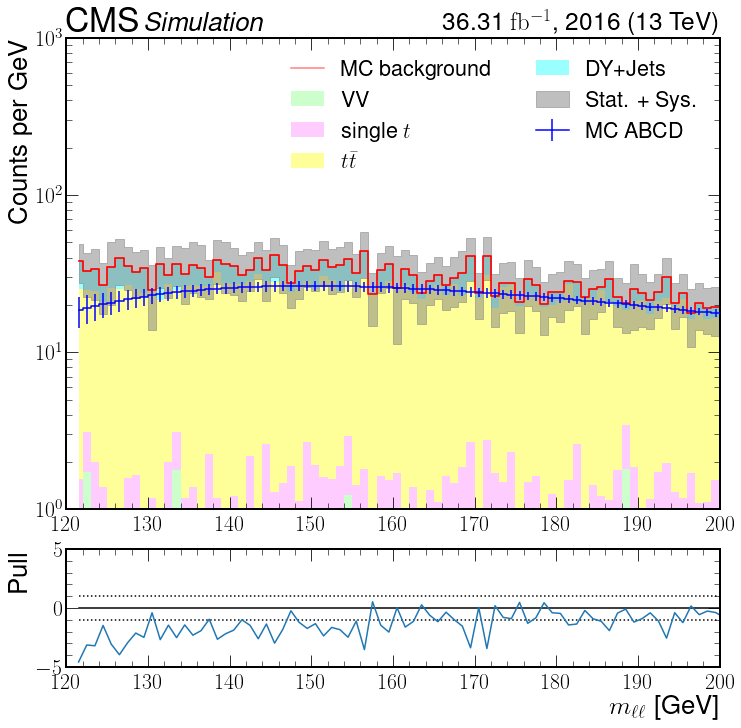

In [109]:
#abcd plots
for nJets in [1,2]:
    reg = 'SR{}'.format(nJets)
    #make abcd hist
    abcd_hist = make_abcd(nJets)
    abcd_hist = abcd_hist.rebin(split_bins.bin_edges).reduce_range(bottom=bottom_value, top=top_value)
    #background hist
    sp.rebin = split_bins.bin_edges
    bhist = sp.combine_back(feature, reg)

    #ratio
    flabel = 'Obs. ABCD' if isdata else 'MC ABCD'
    ratio_dict = compare_hists(abcd_hist.make_density_hist(), bhist.make_density_hist(), isdata=0, n=comp_hist_n, 
                                   color = 'red', ndof=5, flabel=flabel, ratio=True, isabcd=1)
    sp.draw_background(ratio_dict['ax'], feature, reg, sys_label='Stat. + Sys.', errorbar=False)
    
    handles, labels = ratio_dict['ax'].get_legend_handles_labels()
    order = [0,1,2,3,4,6,5]
    if ismc: order = np.linspace(0,len(handles)-1, len(handles), dtype=int)
    ratio_dict['ax'].legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
                                ncol=2)
    
    ratio_dict['ax'].set_ylim(bottom=1e0, top=1e3)
    ratio_dict['fig'].savefig('{}/abcd_mc_ratio_era{}_ismc{}_regSR{}_bottom{}_lognorm_splt_binning.pdf'.format(outdir,era,ismc,nJets,bottom_value))
    ##200 GeV zoom in 
    #ratio_dict['ax'].set_xlim(left=bottom_value, right=200)
    #ratio_dict['rax'].set_xlim(left=bottom_value, right=200)
    #ratio_dict['fig'].savefig('{}/abcd_mc_ratio_era{}_ismc{}_regSR{}_bottom{}_lognorm_splt_binning_200GeVMax.pdf'.format(outdir,era,ismc,nJets,bottom_value))
    
    #pull
    pull_dict = compare_hists(abcd_hist.make_density_hist(), bhist.make_density_hist(), isdata=0, n=comp_hist_n, 
                                   color = 'red', ndof=5, flabel=flabel, ratio=False, isabcd=1)
    sp.draw_background(pull_dict['ax'], feature, reg, sys_label='Stat. + Sys.', errorbar=False)
    handles, labels = pull_dict['ax'].get_legend_handles_labels()
    order = [0,1,2,3,4,6,5]
    if ismc: order = np.linspace(0,len(handles)-1, len(handles), dtype=int)
    pull_dict['ax'].legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
                                ncol=2)
    pull_dict['ax'].set_ylim(bottom=1e0, top=1e3)
    pull_dict['fig'].savefig('{}/abcd_mc_pull_era{}_ismc{}_regSR{}_bottom{}_lognorm_splt_binning.pdf'.format(outdir,era,ismc,nJets,bottom_value))
    #200 GeV zoom in 
    pull_dict['ax'].set_xlim(left=bottom_value, right=200)
    pull_dict['rax'].set_xlim(left=bottom_value, right=200)
    pull_dict['fig'].savefig('{}/abcd_mc_pull_era{}_ismc{}_regSR{}_bottom{}_lognorm_splt_binning_200GeVMax.pdf'.format(outdir,era,ismc,nJets,bottom_value))
    sp.rebin = 0

    #save data
    fit_dict['SR{}'.format(nJets)]= ratio_dict
    fit_dict['SR{}'.format(nJets)]['fit_hist'] = abcd_hist

In [90]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


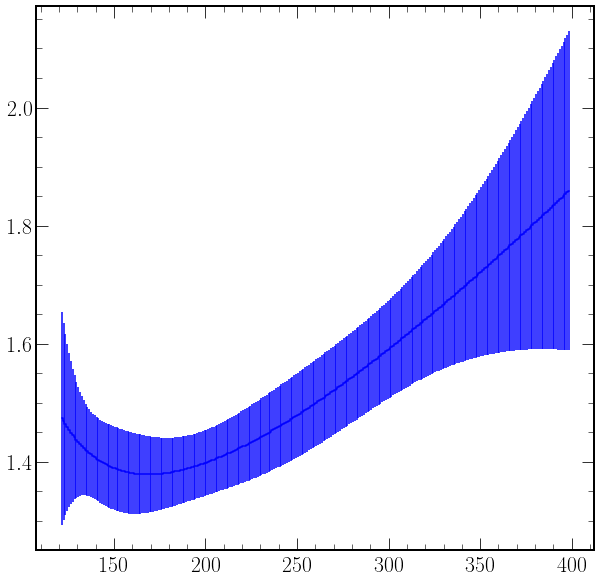

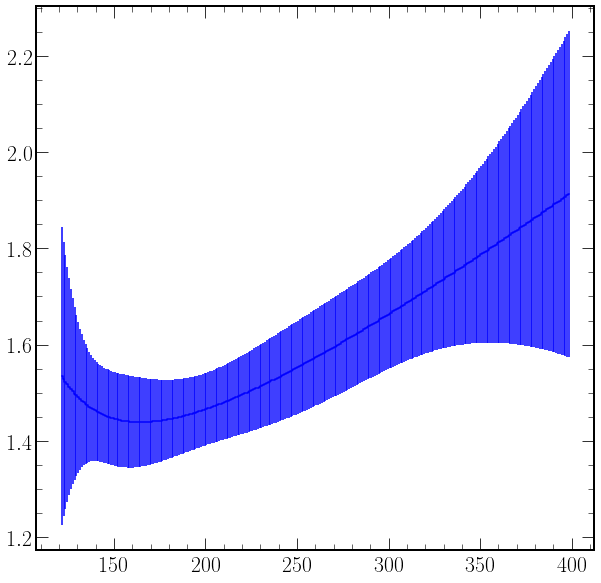

In [110]:
#transfer factor plot
def make_TF(nJets):
    A = make_fit_hist(bhist, 'CR{}3'.format(nJets))
    _nJets = 2 if nJets==2 else ""
    B = make_fit_hist(bhist, 'CRA{}'.format(_nJets))
    C = make_fit_hist(bhist, 'CRB{}'.format(_nJets))
    tf = B.uncertainty_std_dev()/C.uncertainty_std_dev()
    
    tf_nom, tf_std = unp_array_to_nom_std(tf)
    return SysHist(tf_nom, tf_nom*0,tf_nom*0,tf_std, A.bin_edges)
#abcd plots
for nJets in [1,2]:
    reg = 'SR{}'.format(nJets)
    #make abcd hist
    tf_hist = make_TF(nJets)
    tf_hist = tf_hist.reduce_range(bottom=bottom_value, top=top_value)
    fig, ax = plt.subplots()
    A = make_fit_hist(bhist, 'CR{}3'.format(nJets))
    _nJets = 2 if nJets==2 else ""
    B = make_fit_hist(bhist, 'CRA{}'.format(_nJets))
    C = make_fit_hist(bhist, 'CRB{}'.format(_nJets))
    #A.calc_ratio(C.nominal).draw(ax)
    tf_hist.draw(ax)
    #C.draw(ax)
    #tf_hist.draw(ax)

In [111]:
{reg: item['chi2'] for reg, item in fit_dict.items()}

{'CRA': 0.9451706830614888,
 'CRA2': 1.3611100533114764,
 'CRB': 1.2365278528806172,
 'CRB2': 1.1125290148022542,
 'CRD': 1.0791657438050704,
 'CRD2': 1.2308739900533032,
 'CRC': 1.385809537266531,
 'CRC2': 1.5108486594914714,
 'CR13': 0.6740520058377372,
 'CR23': 1.0148100358427499,
 'SR1': 5.1854929673835946,
 'SR2': 2.4083451509517007}

In [112]:
import inspect

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


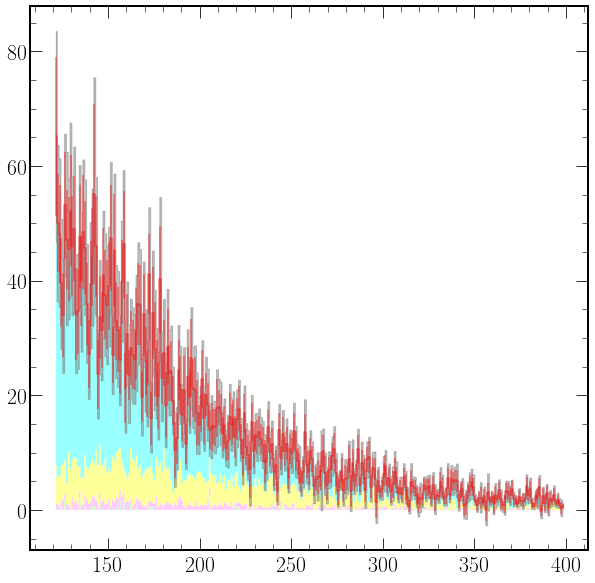

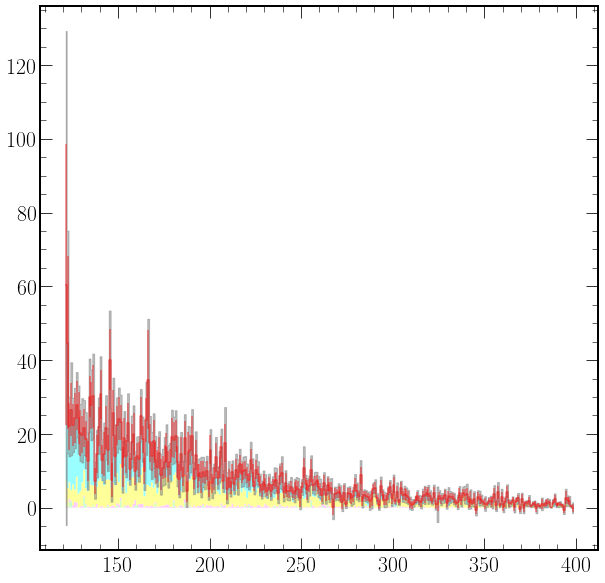

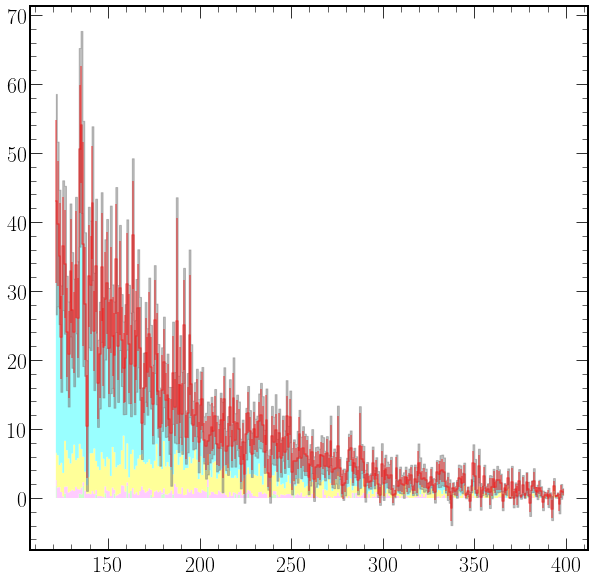

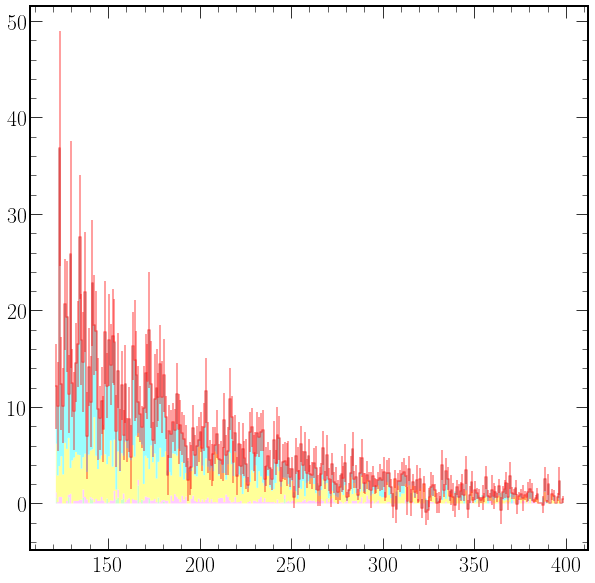

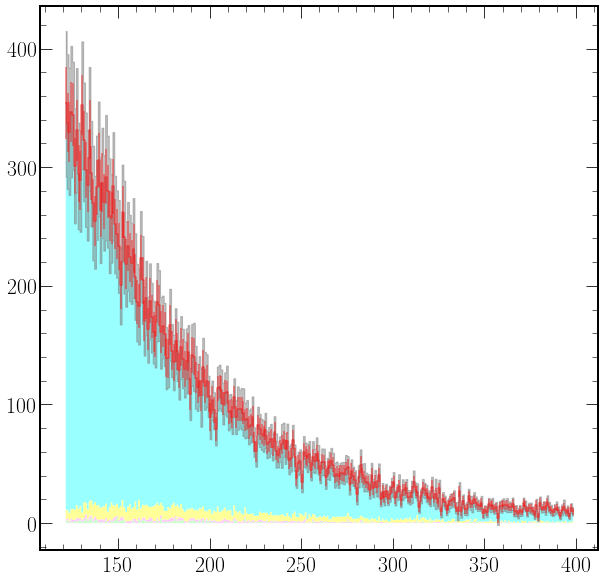

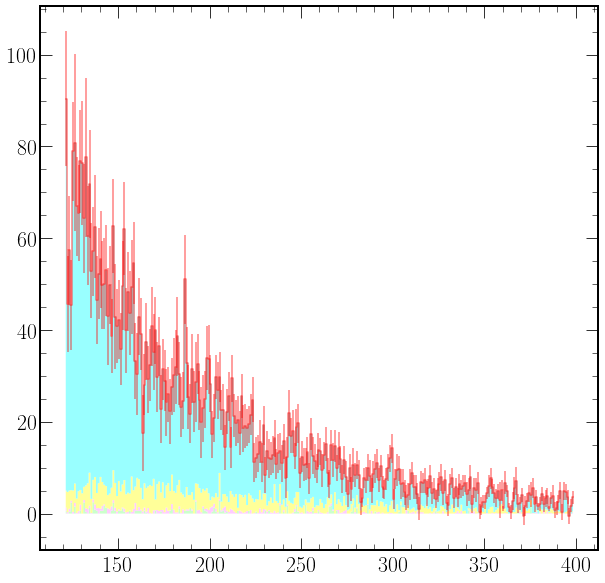

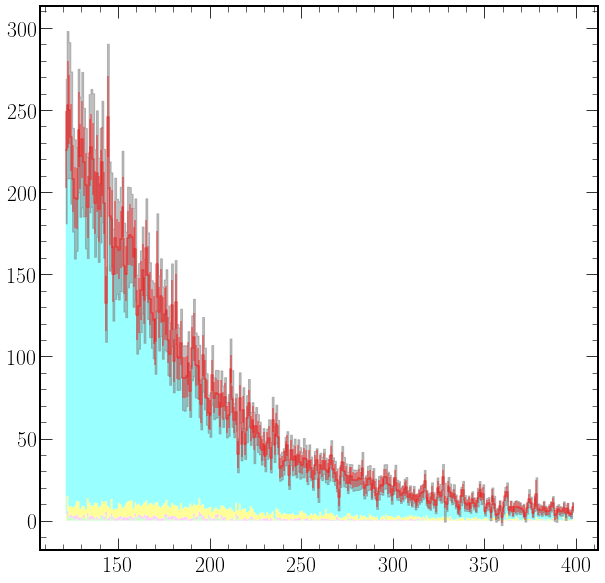

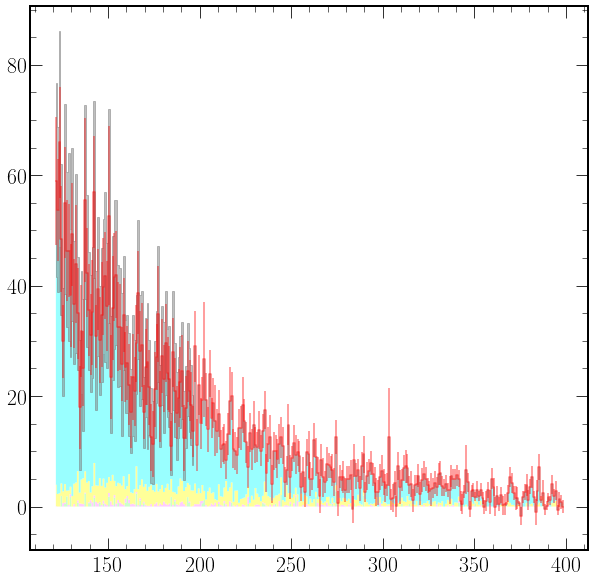

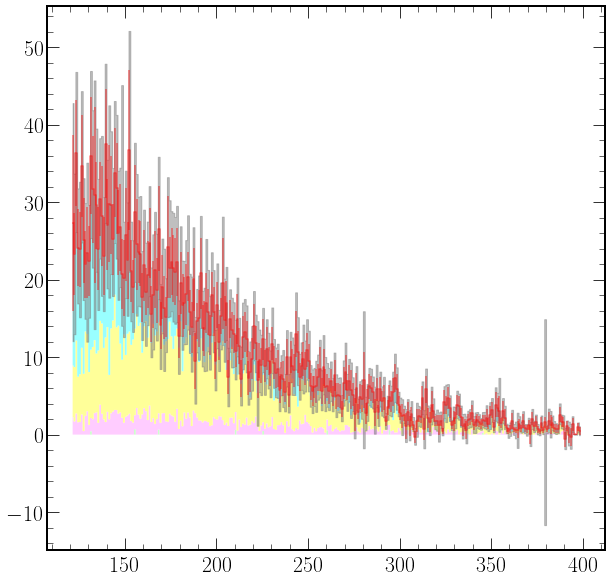

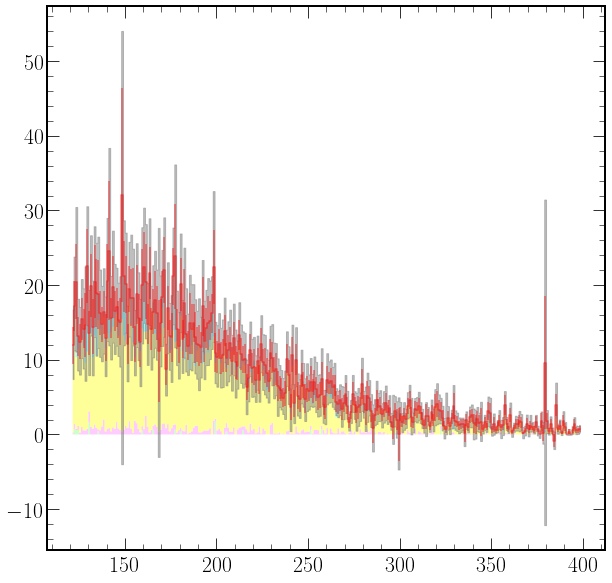

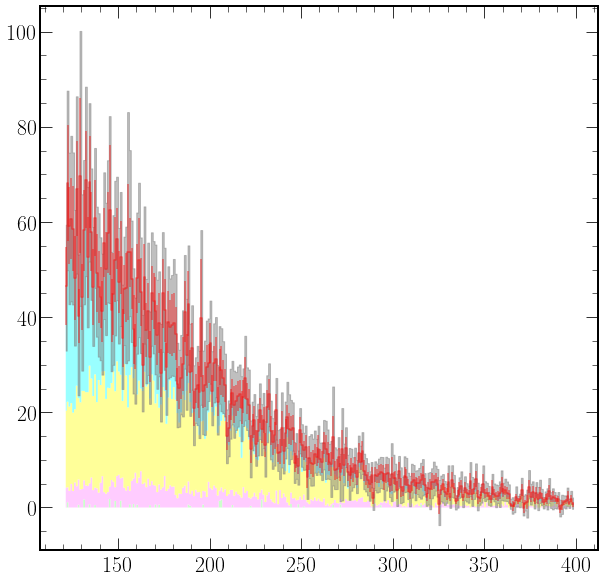

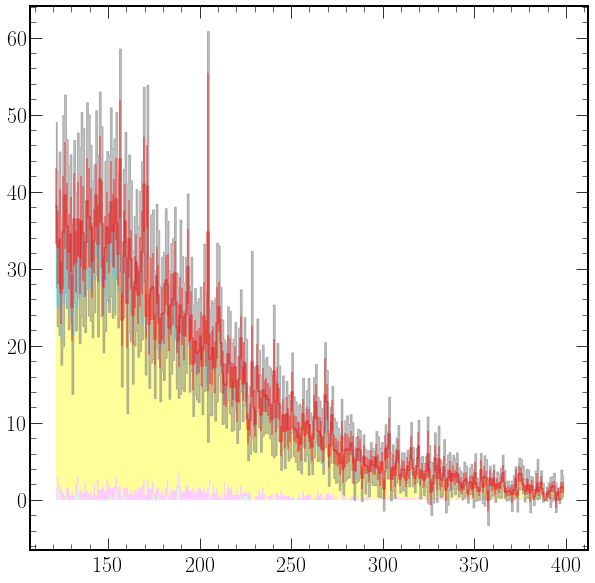

In [113]:
fit_list = []
for reg, item in fit_dict.items():
    if isdata:
        _plot_dict = sp.make_data_hist(feature, reg).reduce_range(bottom=bottom_value, top=top_value)
    else:
        fig, ax = plt.subplots()
        _plot_dict = sp.draw_background(ax, feature, reg).reduce_range(bottom=bottom_value, top=top_value)
    _fit_dict = {
        "era": era,
        "region": reg,
    'n_{background}': "{:.2f}".format(_plot_dict.uncertainty_std_dev().sum()),
    'n_{ABCD,Data}': "{:.2f}".format(item['fit_hist'].uncertainty_std_dev().sum()),
    ' Data $\chi^2/n_{DOF}$': "{:.2f}".format(item['chi2'])
    }
    if not 'SR' in reg:
        popt_unc = uncertainties.correlated_values(item['popt'], item['pcov'])
        param_names = inspect.getfullargspec(log_norm_np).args[1:]
        treg_dict = {**{n:"{:.2f}".format(u) for u, n in zip(popt_unc, param_names) }}
        _fit_dict = {**_fit_dict, **treg_dict}    
    fit_list.append(_fit_dict)

In [114]:
with open('{}/fit_stats_data_{}_ismc{}.txt'.format(outdir,era, ismc), 'w') as f:
    latex = pd.DataFrame(fit_list)[['era', 'region', 'n_{background}',  'n_{ABCD,Data}', 'sigma', 'theta', 'mean',
       ' Data $\chi^2/n_{DOF}$']].to_latex(index=False)
    print(latex)
    f.write(latex)

\begin{tabular}{llllllll}
\toprule
 era & region &    n\_\{background\} &    n\_\{ABCD,Data\} &       sigma &         theta &           mean &  Data \$\textbackslash chi\textasciicircum 2/n\_\{DOF\}\$ \\
\midrule
2016 &    CRA &   3824.96+/-72.24 &  3824.96+/-11.78 & 0.68+/-0.13 & 50.00+/-49.49 &  89.03+/-20.90 &                   0.95 \\
2016 &   CRA2 &   2211.06+/-68.16 &  2211.06+/-10.70 & 0.67+/-0.18 & 50.00+/-70.37 & 100.00+/-34.79 &                   1.36 \\
2016 &    CRB &   2717.22+/-64.75 &  2717.22+/-11.11 & 0.61+/-0.13 & 50.00+/-50.59 &  94.17+/-27.86 &                   1.24 \\
2016 &   CRB2 &   1480.36+/-43.77 &   1480.36+/-7.75 & 0.62+/-0.15 & 54.22+/-54.41 & 100.00+/-33.04 &                   1.11 \\
2016 &    CRD & 24596.21+/-197.69 & 24596.21+/-32.88 & 0.76+/-0.05 & 62.13+/-19.39 &   74.44+/-6.00 &                   1.08 \\
2016 &   CRD2 &   5199.42+/-93.88 &  5199.42+/-15.33 & 0.80+/-0.17 & 50.00+/-74.68 &  78.76+/-14.57 &                   1.23 \\
2016 &    CRC & 174

In [98]:
print(pd.DataFrame(fit_list)[['era', 'region', 'n_{background}',  'n_{ABCD,Data}', 'sigma', 'theta', 'mean',
       ' Data $\chi^2/n_{DOF}$']].to_csv())

,era,region,n_{background},"n_{ABCD,Data}",sigma,theta,mean, Data $\chi^2/n_{DOF}$
0,2016,CRA,4112.00+/-64.12,4112.00+/-7.76,0.81+/-0.11,80.60+/-17.96,76.30+/-8.64,0.98
1,2016,CRA2,2369.00+/-48.67,2369.00+/-5.56,0.70+/-0.18,51.98+/-50.51,98.24+/-27.21,0.92
2,2016,CRB,2781.00+/-52.74,2781.00+/-6.63,0.68+/-0.16,59.35+/-39.89,86.45+/-22.14,1.24
3,2016,CRB2,1629.00+/-40.36,1629.00+/-5.25,0.70+/-0.23,56.79+/-58.45,100.00+/-33.22,1.01
4,2016,CRD,27063.00+/-164.51,27063.00+/-18.35,0.72+/-0.05,65.63+/-10.44,77.80+/-5.16,1.03
5,2016,CRD2,6096.00+/-78.08,6096.00+/-7.76,0.81+/-0.13,50.00+/-48.01,74.01+/-10.33,0.76
6,2016,CRC,18563.00+/-136.25,18563.00+/-15.09,0.77+/-0.05,72.85+/-10.41,74.88+/-4.87,1.00
7,2016,CRC2,4157.00+/-64.47,4157.00+/-7.65,0.85+/-0.21,50.00+/-80.21,71.24+/-10.79,1.02
8,2016,CR13,2331.00+/-48.28,2331.00+/-5.89,0.61+/-0.12,63.71+/-27.15,100.00+/-19.81,0.99
9,2016,CR23,1879.00+/-43.35,1879.00+/-4.46,0.61+/-0.09,74.86+/-16.00,100.00+/-12.59,0.82
10,2016,SR1,0.00+/-0,3463.26+/-13

In [73]:
4112/2717*2734, 5177, 2211/1480*2122, 3780,

(4137.728376886272, 5177, 3170.095945945946, 3780)

In [25]:
tdf = pd.DataFrame(fit_list)[['era', 'region', 'n_{background}',  'sigma', 'theta', 'mean', 'n_{ABCD,Data}',
       ' Data $\chi^2/n_{DOF}$']]
tdf

era region   n_{background}        sigma          theta            mean  \
0  2016    CRA  3824.96+/-72.24  0.68+/-0.13  50.00+/-49.49   89.03+/-20.90   
1  2016   CRA2  2211.06+/-68.16  0.67+/-0.18  50.00+/-70.37  100.00+/-34.79   
2  2016    CRB  2717.22+/-64.75  0.61+/-0.13  50.00+/-50.59   94.17+/-27.86   
3  2016   CRB2  1480.36+/-43.77  0.62+/-0.15  54.22+/-54.41  100.00+/-33.04   
4  2016   CR13  2734.35+/-51.18  0.58+/-0.07  62.04+/-21.99  100.00+/-15.87   
5  2016   CR23  2122.67+/-41.73  0.56+/-0.05  77.85+/-10.57   100.00+/-9.41   

     n_{ABCD,Data}  Data $\chi^2/n_{DOF}$  
0  3824.96+/-11.78                   0.95  
1  2211.06+/-10.70                   1.36  
2  2717.22+/-11.11                   1.24  
3   1480.36+/-7.75                   1.11  
4   2734.35+/-8.54                   0.67  
5   2122.67+/-5.75                   1.01

In [26]:
#format dict for saving
limit_dict = {}
for reg, item in fit_dict.items():
    limit_dict[reg] = item['fit_hist'].to_dict()

In [27]:
import pickle as pkl
with open('{}/abcd_dict_data_{}_ismc{}.pkl'.format(outdir, era, ismc), 'wb') as f:
    pkl.dump(limit_dict, f)

In [28]:
fit_dict_skimmed = {}
for k, v in fit_dict.items():
    v = {k2:v2 for k2,v2 in v.items() if not k2 in ['fig', 'ax','rax']}
    fit_dict_skimmed[k] = v

In [29]:
import pickle as pkl
with open('{}/fit_dict_data_{}_ismc{}.pkl'.format(outdir, era, ismc), 'wb') as f:
    pkl.dump(fit_dict_skimmed, f)

In [30]:
'{}/abcd_dict_data_{}_ismc{}.pkl'.format(outdir, era, ismc)

'/eos/cms/store/group/phys_exotica/bffZprime/assets_june_23/abcd_LCR_to_SR/abcd_dict_data_2016_ismc1.pkl'

In [31]:
##
## sample from covariance
##

In [32]:
import copy

In [35]:
reg = 'CR10'
popt = fit_dict[reg]['popt']
pcov = fit_dict[reg]['pcov']
popt_unc = uncertainties.correlated_values(popt, pcov)

pcov, popt

(array([[ 3.40368752e+08, -8.48652651e+02, -3.28648646e+05,
          9.76268246e+04],
        [-8.48652651e+02,  2.56633270e-03,  8.73958378e-01,
         -2.96311948e-01],
        [-3.28648646e+05,  8.73958378e-01,  3.24536164e+02,
         -1.01051776e+02],
        [ 9.76268246e+04, -2.96311948e-01, -1.01051776e+02,
          3.46326564e+01]]),
 array([1.03112148e+05, 7.39721917e-01, 6.17840927e+01, 7.34084130e+01]))

In [36]:
def log_norm_unp_safe(*args):
    try:
        return log_norm_unp(*args)
    except:
        return 0
    
def make_hists_region(reg, n_random = 10):
    popt = fit_dict[reg]['popt']
    pcov = fit_dict[reg]['pcov']
    popt_unc = uncertainties.correlated_values(popt, pcov)
    nvars = len(popt)
    # covariance matrix version
    _x = np.array(split_bins.calc_bin_centers())
    _x = np.linspace(120,400, 100)
    
    _y = log_norm_unp(_x, *popt_unc)
    _y_nom, _y_std = unp_array_to_nom_std(_y)
    
    #"square root" of covariance matrix
    w, v = np.linalg.eig(pcov)
    sigma = np.sqrt(w) * v
    #print(np.linalg.cholesky(pcov))
    
    #do extras so we can drop invalid params
    random_popts = np.random.default_rng().multivariate_normal(popt, pcov, n_random)
    
    y_randoms = np.apply_along_axis(lambda p: abs(log_norm_unp_safe(_x, *p)), 1, random_popts)
    y_randoms = [y for y in y_randoms if not type(y)==int]
    #cut down to length
    y_randoms = y_randoms[:n_random]
    #implied mc uncertainties:
    array = np.stack(y_randoms).astype('float')
    mc_unc = array.std(axis=0)
    mc_unc

    return {"y": _y, "y_nom": _y_nom, "y_std": _y_std, "x": _x, "random_popts": random_popts, "y_randoms": np.array(y_randoms).astype('float'), "popt_unc": popt_unc, 'pcov': pcov, 'mc_unc': mc_unc}

In [37]:
def log_norm_unp_safe(*args):
    try:
        return log_norm_unp(*args)
    except:
        return 0
    
def make_hists_region(reg, n_random = 10):
    popt = fit_dict[reg]['popt']
    pcov = fit_dict[reg]['pcov']
    popt_unc = uncertainties.correlated_values(popt, pcov)
    nvars = len(popt)
    # covariance matrix version
    _x = np.array(split_bins.calc_bin_centers())
    _x = np.linspace(120,400, 100)
    
    _y = log_norm_unp(_x, *popt_unc)
    _y_nom, _y_std = unp_array_to_nom_std(_y)
    
    #"square root" of covariance matrix
    w, v = np.linalg.eig(pcov)
    sigma = np.sqrt(w) * v
    #print(np.linalg.cholesky(pcov))
    
    #do extras so we can drop invalid params
    random_popts = (sigma @ np.random.randn(nvars, int(n_random*1.5))).T + popt
    #random_popts = np.matmul(np.random.rand(n_random, nvars),np.linalg.cholesky(pcov))+popt
    
    y_randoms = list(map(lambda p: abs(log_norm_unp_safe(_x, *p)), random_popts))
    y_randoms = [y for y in y_randoms if not type(y)==int]
    #cut down to length
    y_randoms = y_randoms[:n_random]
    #implied mc uncertainties:
    array = np.stack(y_randoms).astype('float')
    mc_unc = array.std(axis=0)

    return {"y": _y, "y_nom": _y_nom, "y_std": _y_std, "x": _x, "random_popts": random_popts, "y_randoms": np.array(y_randoms).astype('float'), "popt_unc": popt_unc, 'pcov': pcov, 'mc_unc': mc_unc}

In [251]:
def make_hists_region(reg, n_random = 10):
    popt = fit_dict[reg]['popt']
    pcov = fit_dict[reg]['pcov']
    popt_unc = uncertainties.correlated_values(popt, pcov)
    nvars = len(popt)
    # covariance matrix version
    _x = np.array(split_bins.calc_bin_centers())
    _x = np.linspace(120,400, 100)
    
    _y = log_norm_unp(_x, *popt_unc)
    _y_nom, _y_std = unp_array_to_nom_std(_y)
    
    #"square root" of covariance matrix
    w, v = np.linalg.eig(pcov)
    sigma = np.sqrt(w) * v
    #print(np.linalg.cholesky(pcov))
    
    #do extras so we can drop invalid params
    # https://stats.stackexchange.com/questions/120179/generating-data-with-a-given-sample-covariance-matrix
    random_popts = np.random.default_rng().multivariate_normal(popt, pcov, n_random).T
    means = (random_popts.mean(axis=1)).reshape(-1,1)
    mean_subtracted = random_popts - means
    
    # Make each variable in X orthogonal to one another
    L_inv = np.linalg.cholesky(np.cov(mean_subtracted, bias = True))
    L_inv = np.linalg.inv(L_inv)
    mean_subtracted = np.dot(L_inv, mean_subtracted)
    
    # Rescale X to exactly match Sigma
    L = np.linalg.cholesky(pcov)
    mean_subtracted = np.dot(L, mean_subtracted)
    print("delta covariance matrix: ", pcov, "\n",  np.cov(mean_subtracted))
    #add means back in
    random_popts = mean_subtracted + means
    #rotate it back
    random_popts = random_popts.T

    y_randoms = np.apply_along_axis(lambda p: abs(log_norm_unp_safe(_x, *p)), 1, random_popts)
    y_randoms = [y for y in y_randoms if not sum(y)==0]
    #cut down to length
    y_randoms = y_randoms[:n_random]
    #implied mc uncertainties:
    array = np.stack(y_randoms).astype('float')
    mc_unc = array.std(axis=0)
    mc_unc

    return {"y": _y, "y_nom": _y_nom, "y_std": _y_std, "x": _x, "random_popts": random_popts, "y_randoms": np.array(y_randoms).astype('float'), "popt_unc": popt_unc, 'pcov': pcov, 'mc_unc': mc_unc}


    

In [39]:
 make_hists_region("CR10")

delta covariance matrix:  [[ 3.40368752e+08 -8.48652651e+02 -3.28648646e+05  9.76268246e+04]
 [-8.48652651e+02  2.56633270e-03  8.73958378e-01 -2.96311948e-01]
 [-3.28648646e+05  8.73958378e-01  3.24536164e+02 -1.01051776e+02]
 [ 9.76268246e+04 -2.96311948e-01 -1.01051776e+02  3.46326564e+01]] 
 [[ 3.78187502e+08 -9.42947390e+02 -3.65165162e+05  1.08474250e+05]
 [-9.42947390e+02  2.85148078e-03  9.71064865e-01 -3.29235498e-01]
 [-3.65165162e+05  9.71064865e-01  3.60595737e+02 -1.12279751e+02]
 [ 1.08474250e+05 -3.29235498e-01 -1.12279751e+02  3.84807293e+01]]


{'y': array([362.81285948034565+/-12.045362554743802,
        352.3040414249013+/-8.999754482150733,
        341.24332905440696+/-6.798424929011971,
        329.8278516576386+/-5.302887958991633,
        318.2187696003966+/-4.37726233203344,
        306.5468256541691+/-3.8672099465157848,
        294.9171762847985+/-3.6114375544216726,
        283.41355266740493+/-3.4785406478977983,
        272.10181679539374+/-3.386227974906275,
        261.0329828233265+/-3.2934433405492425,
        250.24577238990236+/-3.1844120224398815,
        239.76876799431622+/-3.0563775957654618,
        229.6222223039763+/-2.9124318278924775,
        219.8195745979613+/-2.7577823882038714,
        210.36871899529942+/-2.5979364097673634,
        201.27306299922483+/-2.4378783253994323,
        192.53240935746769+/-2.281746658360755,
        184.14368934274447+/-2.1327539472047112,
        176.10157128728864+/-1.9932199493450125,
        168.39896451963236+/-1.86465370585844,
        161.0274356953106+/-1.74

In [40]:
import seaborn as sns
def make_cov_plots(cov_dict, region):
    length = len(cov_dict['y_randoms'])
    
    #plot fit information
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    
    #mc fits
    ax.errorbar([0,1], [0,1], color='red', zorder=0, label='MC fit variations')
    for i, y in enumerate(cov_dict['y_randoms']): 
        ax.errorbar(cov_dict['x'],  y/cov_dict['y_nom'], alpha=20/length, color='red', zorder=0)
    
    #covariance fit
    ax.errorbar(cov_dict['x'], cov_dict['y_nom']/cov_dict['y_nom'], yerr=cov_dict['y_std']/cov_dict['y_nom'], zorder=2, label='From covariance')
    
    ax.legend()
    ax.set_xlim(110,400)
    ax.set_ylim(.5, 1.5)
    cms_format_fig(era, ax, "\emph{Preliminary}")
    ax.set_xlabel('$m_{\ell\ell}$ [GeV]')
    ax.set_ylabel('$f(x)_{var.}/f(x)_{nom.}$')
    fig.savefig(f'{outdir}/fit_corr_MC_fits_{era}_{ismc}_{region}.pdf')
    
    #implied error
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.plot(cov_dict['x'], cov_dict['y_std']/cov_dict['y_nom'], label='Std. Dev. from Cov. Matrix')
    ax.plot(cov_dict['x'], cov_dict['mc_unc']/cov_dict['y_nom'], label='Std. Dev. from MC',  color='red')
    ax.set_xlim(110,400)
    ax.set_ylim(0,.3)
    ax.legend()
    ax.set_ylabel('(Per Bin Uncertainty)/Nominal')
    ax.set_xlabel('$m_{\ell\ell}$ [GeV]')
    cms_format_fig(era, ax, "\emph{Preliminary}")
    fig.savefig(f'{outdir}/fit_corr_implied_error_{era}_{ismc}_{region}.pdf')
    
    #correlation plot
    fig, ax = plt.subplots(1,1, figsize=(12,12))
    
    corrcoef = np.corrcoef(cov_dict['y_randoms'].T)
    
    df_corrcoef = pd.DataFrame(corrcoef, index = cov_dict['x'].round(),
                  columns = cov_dict['x'].round())

    sns.heatmap(df_corrcoef, annot=False,
               vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True)
    
    #ticks = np.linspace(120, 400, int((400-120)/10+1), dtype='int')
    #ax.set_xticklabels(ticks)
    #ax.set_yticklabels(ticks)
    ax.set_xlabel('$m_{\ell\ell}$ [GeV]')
    ax.set_ylabel('$m_{\ell\ell}$ [GeV]')
    cms_format_fig(era, ax, "\emph{Preliminary}")
    fig.savefig(f'{outdir}/fit_corr_corrplot_{era}_{ismc}_{region}.pdf')
    
    #envelope plot
    
    fig, ax = plt.subplots( figsize=(12,12))
    cov_dict_randoms_sorted = sorted(cov_dict['y_randoms'], key=lambda x: x[0])
    
    #bottom 300
    for i, y in enumerate(cov_dict_randoms_sorted[int(length*(1-.165)): int(length*(1-.155))]): 
        ax.errorbar(cov_dict['x'],  y/cov_dict['y_nom'], alpha=20/length, color='red', zorder=0)
            
    for i, y in enumerate(cov_dict_randoms_sorted[int(length*(.155)): int(length*(.165))]): 
        ax.errorbar(cov_dict['x'],  y/cov_dict['y_nom'], alpha=20/length, color='blue', zorder=0)
        
    
    up = np.array(cov_dict_randoms_sorted[int(length*(1-.165)): int(length*(1-.155))]).mean(axis=0)
    down = np.array(cov_dict_randoms_sorted[int(length*(.155)): int(length*(.165))]).mean(axis=0)
    
    
    ax.errorbar(pdictB['x'],  up/cov_dict['y_nom'], color='blue', zorder=0, label='approx 68\% env up')
    ax.errorbar(pdictB['x'],  down/cov_dict['y_nom'],  color='red', zorder=0, label='approx 68\% env down')
    
    ax.set_ylabel('$f(x)_{var.}/f(x)_{nom.}$')
    ax.set_xlabel('$m_{\ell\ell}$ [GeV]')
    ax.errorbar(cov_dict['x'], cov_dict['y_nom']/cov_dict['y_nom'], yerr=cov_dict['y_std']/cov_dict['y_nom'], zorder=2, label='From covariance')
    cms_format_fig(era, ax, "\emph{Preliminary}")
    ax.set_xlim(110,400)
    ax.set_ylim(.5, 1.5)
    ax.legend()
    fig.savefig(f'{outdir}/fit_corr_envplot_{era}_{ismc}_{region}.pdf')
    
    #fig.savefig('{outdir}/fit_corr_'.format(outdir,era,ismc,nJets,bottom_value))
    

In [41]:
length = 10000
pdictB = make_hists_region('CR10', n_random=length)

pdictC = make_hists_region('CR13', n_random=length)

pdictD = make_hists_region('CR14', n_random=length)
ABCD_randoms = (pdictB['y_randoms']*pdictC['y_randoms']/pdictD['y_randoms'])
ABCD_unc = ABCD_randoms.std(axis=0)
ABCD = pdictB['y']*pdictC['y']/pdictD['y']
ABCD_nom, ABCD_std = unp_array_to_nom_std(ABCD)   

ABCD_dict = {"y": ABCD, "y_nom": ABCD_nom, "y_std": ABCD_std, "x": pdictD['x'], "y_randoms": ABCD_randoms, "mc_unc":ABCD_unc }

delta covariance matrix:  [[ 3.40368752e+08 -8.48652651e+02 -3.28648646e+05  9.76268246e+04]
 [-8.48652651e+02  2.56633270e-03  8.73958378e-01 -2.96311948e-01]
 [-3.28648646e+05  8.73958378e-01  3.24536164e+02 -1.01051776e+02]
 [ 9.76268246e+04 -2.96311948e-01 -1.01051776e+02  3.46326564e+01]] 
 [[ 3.40402792e+08 -8.48737525e+02 -3.28681514e+05  9.76365882e+04]
 [-8.48737525e+02  2.56658936e-03  8.74045783e-01 -2.96341582e-01]
 [-3.28681514e+05  8.74045783e-01  3.24568620e+02 -1.01061882e+02]
 [ 9.76365882e+04 -2.96341582e-01 -1.01061882e+02  3.46361200e+01]]
delta covariance matrix:  [[ 5.20725829e+05 -4.25755752e+01 -1.47983056e+04  1.00492517e+04]
 [-4.25755752e+01  4.93085116e-03  1.49839828e+00 -1.10159162e+00]
 [-1.47983056e+04  1.49839828e+00  4.83585946e+02 -3.45101661e+02]
 [ 1.00492517e+04 -1.10159162e+00 -3.45101661e+02  2.51833825e+02]] 
 [[ 5.20777907e+05 -4.25798332e+01 -1.47997856e+04  1.00502567e+04]
 [-4.25798332e+01  4.93134429e-03  1.49854813e+00 -1.10170179e+00]
 [-

/tmp/rymuelle/ipykernel_16245/558299726.py:7: RuntimeWarning: divide by zero encountered in true_divide
  ABCD_randoms = (pdictB['y_randoms']*pdictC['y_randoms']/pdictD['y_randoms'])
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/env/lib/python3.9/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [42]:
ABCD_std

array([7.34448517, 5.65604643, 4.40000109, 3.50138943, 2.89486873,
       2.51413731, 2.29010495, 2.15959582, 2.07508224, 2.00692009,
       1.93954042, 1.86636854, 1.78588137, 1.69910445, 1.60816608,
       1.51550581, 1.42346087, 1.33406367, 1.24895515, 1.16936049,
       1.09609866, 1.0296108 , 0.97000076, 0.91708448, 0.87044668,
       0.82950217, 0.7935582 , 0.76187347, 0.73370912, 0.70836891,
       0.68522682, 0.66374295, 0.64346918, 0.62404744, 0.60520273,
       0.58673338, 0.5685001 , 0.55041504, 0.53243154, 0.514535  ,
       0.49673501, 0.47905875, 0.46154555, 0.44424251, 0.42720106,
       0.41047421, 0.39411451, 0.37817244, 0.3626953 , 0.34772634,
       0.33330415, 0.31946232, 0.30622909, 0.29362726, 0.28167408,
       0.27038122, 0.2597548 , 0.24979547, 0.24049855, 0.23185416,
       0.22384751, 0.21645918, 0.20966553, 0.20343915, 0.19774942,
       0.19256308, 0.18784488, 0.18355828, 0.17966606, 0.17613098,
       0.17291637, 0.16998663, 0.16730769, 0.16484731, 0.16257

/cvmfs/cms.cern.ch/slc7_amd64_gcc900/external/py3-mplhep/0.3.12-7035ea3f07f1140591d576e2b24108c3/lib/python3.9/site-packages/mplhep/label.py:124: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ax.figure.canvas.draw()
/cvmfs/cms.cern.ch/slc7_amd64_gcc900/external/py3-mplhep/0.3.12-7035ea3f07f1140591d576e2b24108c3/lib/python3.9/site-packages/mplhep/label.py:144: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ax.figure.canvas.draw()
/tmp/rymuelle/ipykernel_16245/2505763017.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(f'{outdir}/fit_corr_MC_fits_{era}_{ismc}_{region}.pdf')
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/env/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/cvmfs/cms.cern.ch/slc7_amd64_gcc900/external/py3-ipytho

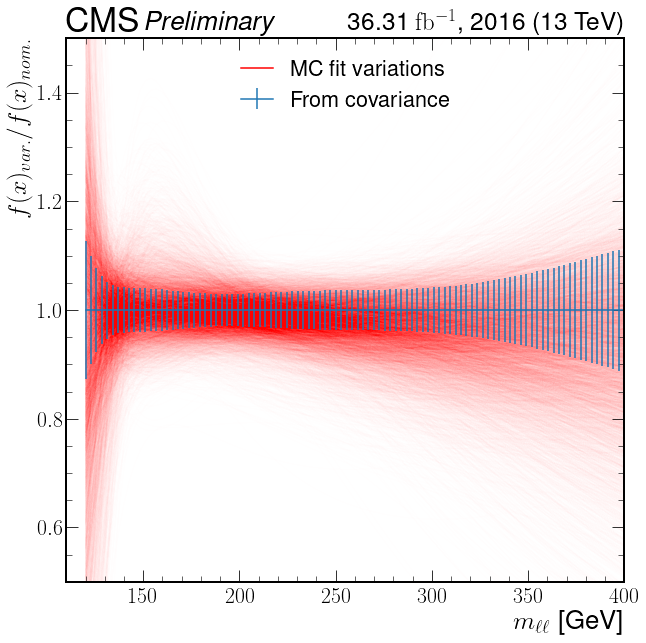

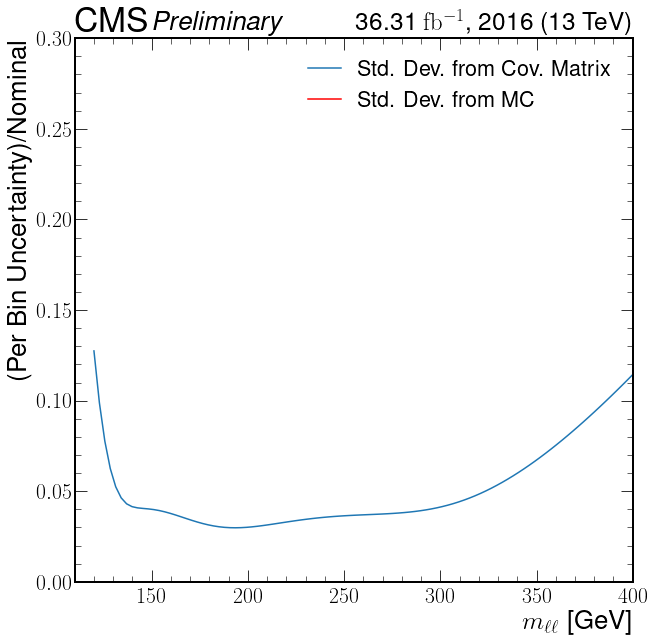

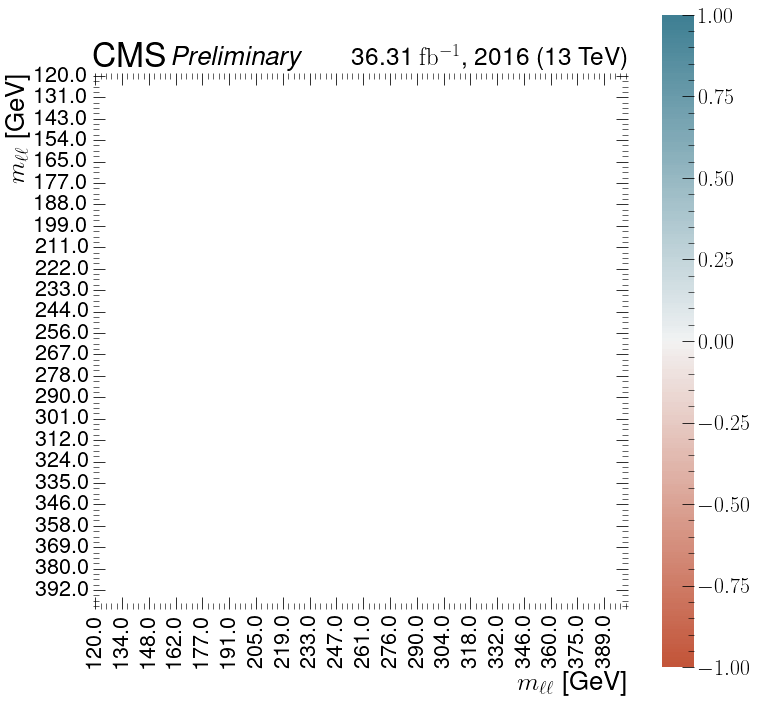

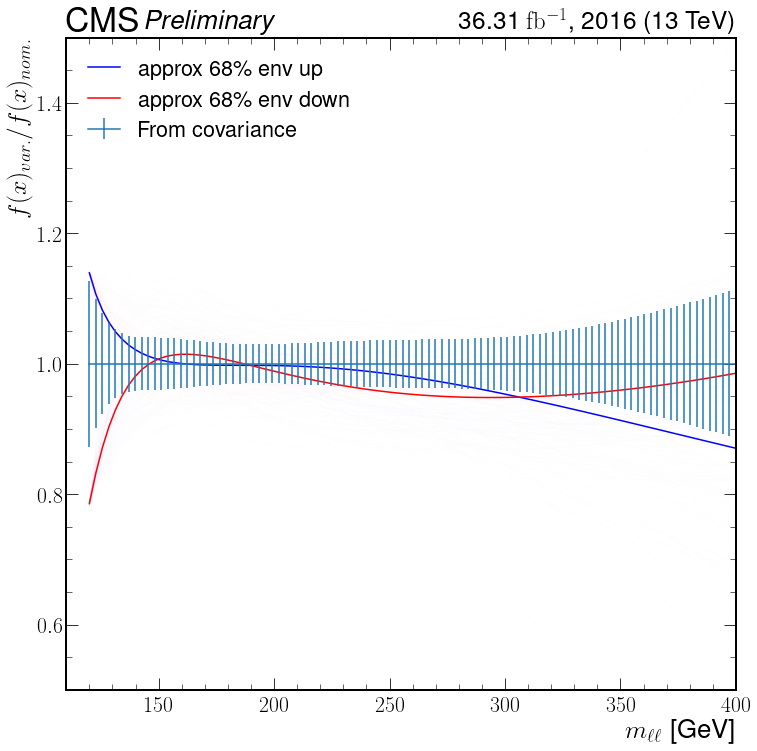

In [43]:
make_cov_plots(ABCD_dict, "SR1")

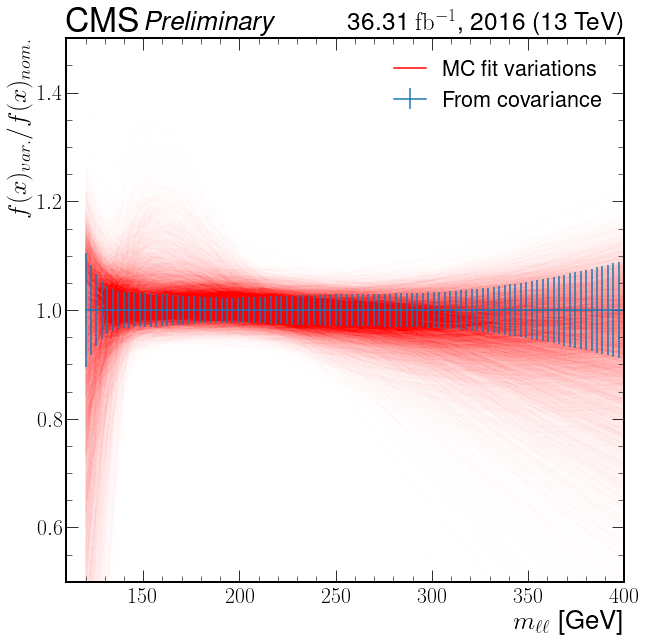

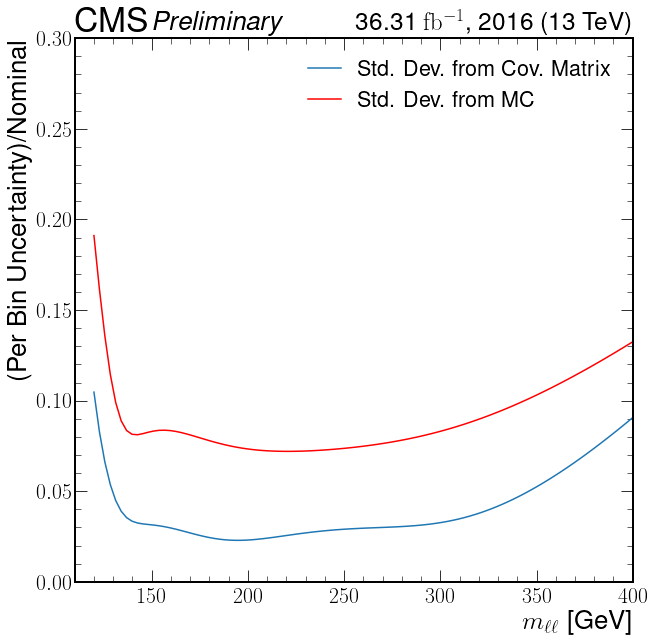

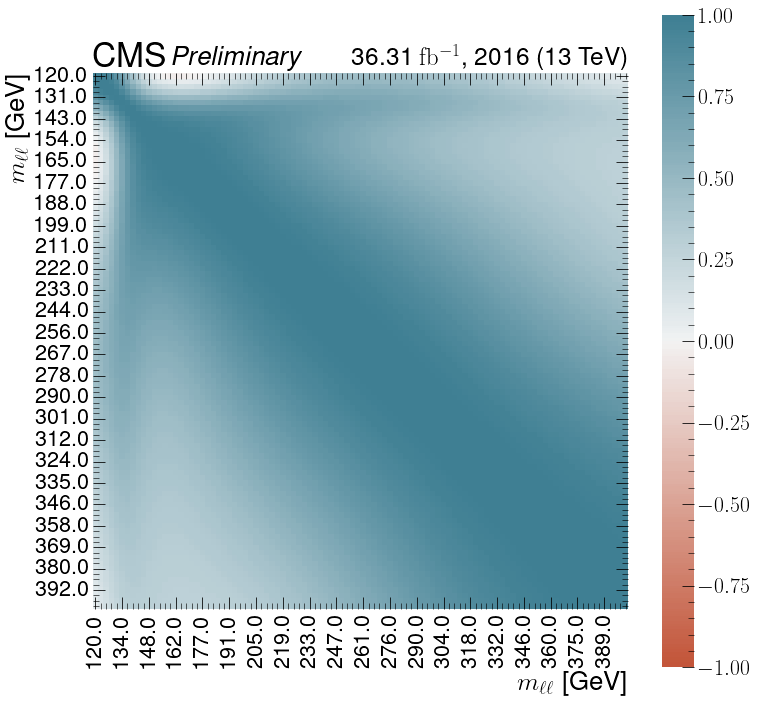

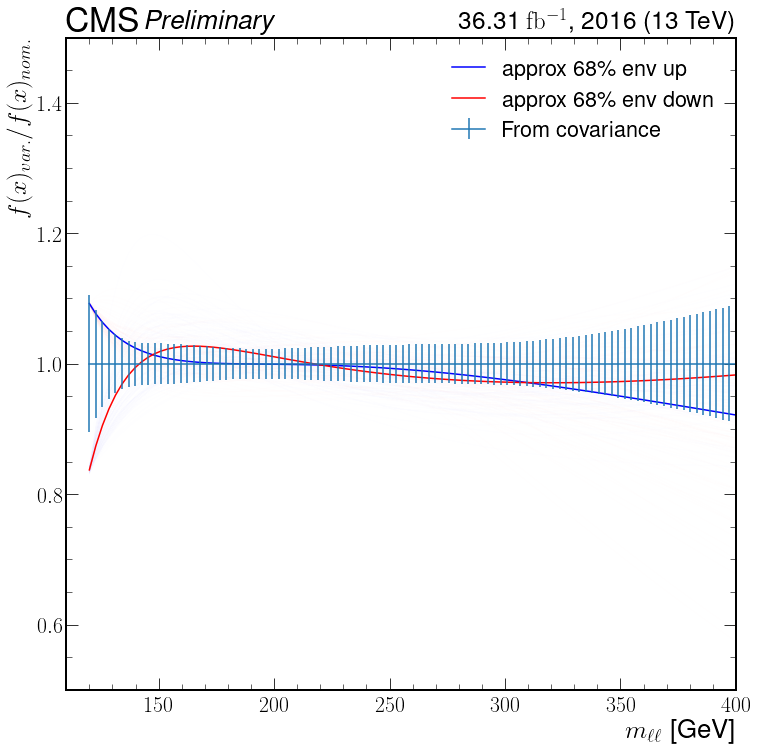

In [212]:
make_cov_plots(pdictB, "CR10")

In [ ]:
make_cov_plots(pdictC, "CR13")

In [ ]:
make_cov_plots(pdictD, "CR14")

In [ ]:
length = 1000
pdictB = make_hists_region('CR20', n_random=length)
pdictC = make_hists_region('CR23', n_random=length)
pdictD = make_hists_region('CR24', n_random=length)
ABCD_randoms = (pdictB['y_randoms']*pdictC['y_randoms']/pdictD['y_randoms'])
ABCD_unc = ABCD_randoms.std(axis=0)
ABCD = pdictB['y']*pdictC['y']/pdictD['y']
ABCD_nom, ABCD_std = unp_array_to_nom_std(ABCD)   

ABCD_dict = {"y": ABCD, "y_nom": ABCD_nom, "y_std": ABCD_std, "x": pdictD['x'], "y_randoms": ABCD_randoms, "mc_unc":ABCD_unc }

In [ ]:
make_cov_plots(ABCD_dict)

In [ ]:
make_cov_plots(pdictB)

In [ ]:
# covariance test

In [314]:
#
pdictB = make_hists_region('CR10', n_random=length)
pdictB.keys()

delta covariance matrix:  [[ 3.40368752e+08 -8.48652651e+02 -3.28648646e+05  9.76268246e+04]
 [-8.48652651e+02  2.56633270e-03  8.73958378e-01 -2.96311948e-01]
 [-3.28648646e+05  8.73958378e-01  3.24536164e+02 -1.01051776e+02]
 [ 9.76268246e+04 -2.96311948e-01 -1.01051776e+02  3.46326564e+01]] 
 [[ 3.40402792e+08 -8.48737525e+02 -3.28681514e+05  9.76365882e+04]
 [-8.48737525e+02  2.56658936e-03  8.74045783e-01 -2.96341582e-01]
 [-3.28681514e+05  8.74045783e-01  3.24568620e+02 -1.01061882e+02]
 [ 9.76365882e+04 -2.96341582e-01 -1.01061882e+02  3.46361200e+01]]


dict_keys(['y', 'y_nom', 'y_std', 'x', 'random_popts', 'y_randoms', 'popt_unc', 'pcov', 'mc_unc'])

In [315]:
# note that the stddev of the random pops is the same as teh stdev from the uncertainty 
pdictB['popt_unc'][0], pdictB['random_popts'][:,0].std()

(103112.14758333478+/-18449.085392322268, 18449.08539232227)

In [316]:
#now, lets sort popts and y_randoms by the first value:
def sort_by_index(i):
    return np.stack(sorted(pdictB['random_popts'], key=lambda x:x[i]))

In [408]:
index = 2
poptsorted = sort_by_index(index)
log_norm_unp

<function src.general.functions.log_norm_unp(x, norm, sigma, theta, mean)>

In [409]:
# def select_envelope(_poptsorted, _index, _envelope=.68):
#     mean, stdev = _poptsorted[:,0].mean(), _poptsorted[:,0].std()
#     up = _poptsorted[]

(array([  18.,  147.,  617., 1748., 2750., 2613., 1494.,  497.,  108.,
           8.]),
 array([ -3.24446167,  10.04593798,  23.33633764,  36.62673729,
         49.91713694,  63.2075366 ,  76.49793625,  89.78833591,
        103.07873556, 116.36913521, 129.65953487]),
 <BarContainer object of 10 artists>)

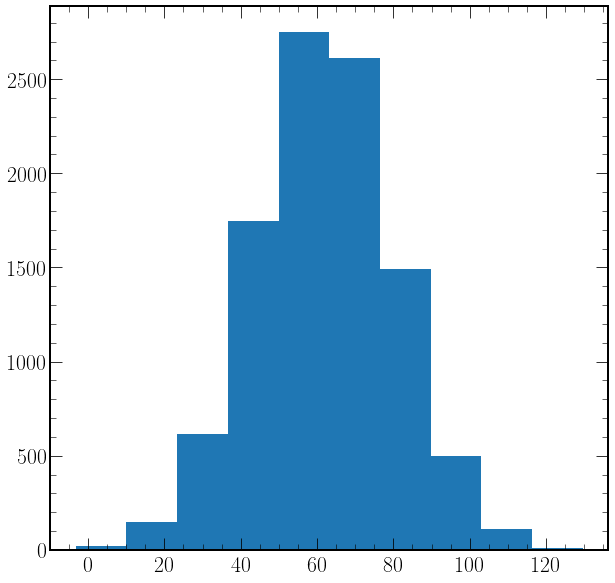

In [410]:
mean, stdev = poptsorted[:,index].mean(), poptsorted[:,index].std()
mean, stdev
plt.hist(poptsorted[:,index])

Text(1, 78.03066503541407, '$m_{\\ell\\ell}$ [GeV]')

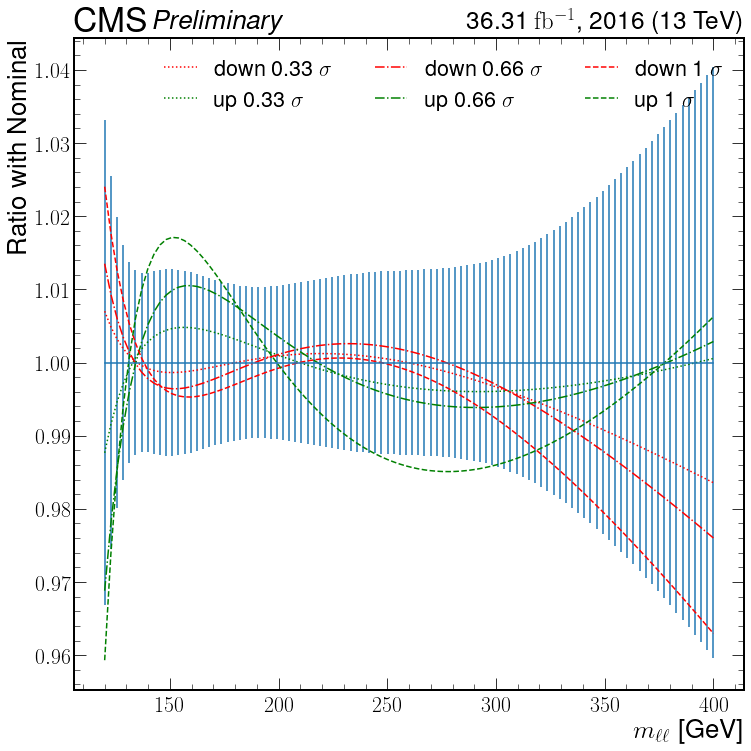

In [435]:
fig, ax = plt.subplots(figsize=(12,12))
x = pdictB['x']
for ls, i in zip([':', "-.", "--"], [.33, .66, 1]):
    sigma =  i
    epsilon = .01
    up_top, up_bottom = mean+stdev*(sigma+epsilon), mean+stdev*(sigma-epsilon) 
    up_pop = poptsorted[(poptsorted[:,index] < up_top) & (poptsorted[:,index] > up_bottom)]
    
    down_top, down_bottom = mean-stdev*(sigma+epsilon), mean-stdev*(sigma-epsilon) 
    down_pop = poptsorted[(poptsorted[:,index] < down_bottom) & (poptsorted[:,index] > down_top)]
    
    x = pdictB['x']
    y_random_up = np.apply_along_axis(lambda p: abs(log_norm_unp_safe(x, *p)), 1, up_pop)
    y_random_up = np.stack([y for y in y_random_up if not type(y)==int])
    
    y_random_down = np.apply_along_axis(lambda p: abs(log_norm_unp_safe(x, *p)), 1, down_pop)
    y_random_down = np.stack([y for y in y_random_down if not type(y)==int])
    
    y_down = y_random_down.mean(axis=0)
    y_up = y_random_up.mean(axis=0)
    y_up.sum(), y_down.sum(), pdictB['y_nom'].sum()
    y_down = y_down/y_down.sum()*pdictB['y_nom'].sum()
    y_up = y_up/y_up.sum()*pdictB['y_nom'].sum()
    
    _ = ax.plot(x, y_down.T/pdictB['y_nom'], label='down {} $\sigma$'.format(i), color='red', ls=ls)
    _ = ax.plot(x, y_up.T/pdictB['y_nom'], label='up {} $\sigma$'.format(i), color='green', ls=ls)
    
    
_ = ax.errorbar(x, pdictB['y_nom']/pdictB['y_nom'], yerr=pdictB['y_std']/pdictB['y_nom'])
ax.legend(ncol=3)

cms_format_fig(era, ax, '\emph{Preliminary}')
ax.set_ylabel('Ratio with Nominal')
ax.set_xlabel('$m_{\ell\ell}$ [GeV]')

0.7048361407577459 0.7190752547124479
-0.6685069850743148 -0.6820121766919778


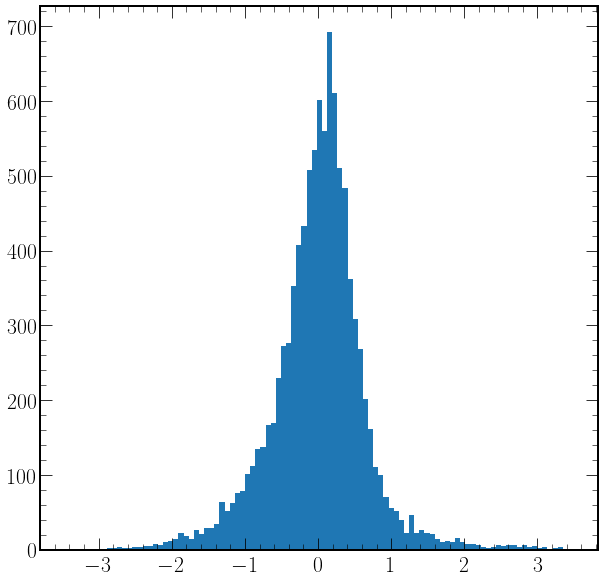

In [404]:
y_randoms_sum = sorted(pdictB['y_randoms'], key=lambda x: sum(x))

foo = lambda x: x[-1]
foo = lambda x: x[-1]-x[0]/47
sums = np.array(list(map(foo, pdictB['y_randoms'])))
mean, std = np.mean(sums), np.std(sums)
mean, std
plt.hist(sums, bins=np.linspace(mean-5*std, mean+5*std, 100))

def get_slice(arr, value, width, foo):
    x = np.array(list(map(foo, arr)))
    print(value*(1-width), value*(1+width))
    xrange = sorted((value*(1-width), value*(1+width)))
    return arr[(x > xrange[0]) &  (x < xrange[1])]


up_slice = get_slice(pdictB['y_randoms'], mean+std, .01, foo)
down_slice = get_slice(pdictB['y_randoms'], mean-std, .01, foo)

y_down = down_slice.mean(axis=0)
y_up = up_slice.mean(axis=0)

In [405]:
y_up.sum(), y_down.sum(), pdictB['y_nom'].sum()

(8739.590473634578, 8813.63201143409, 8964.920637966472)

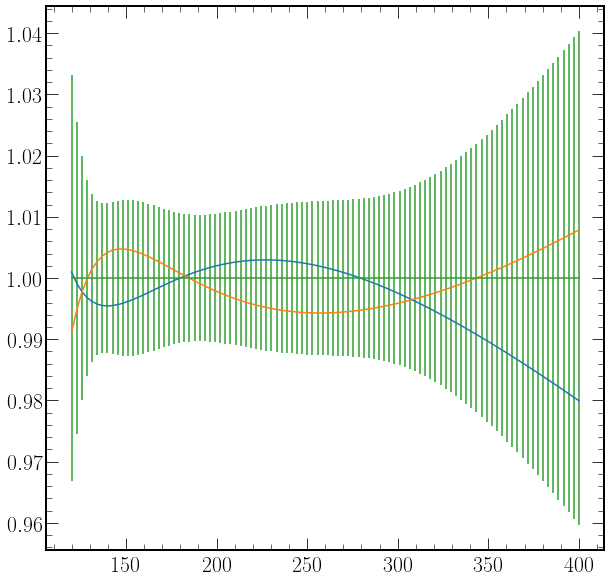

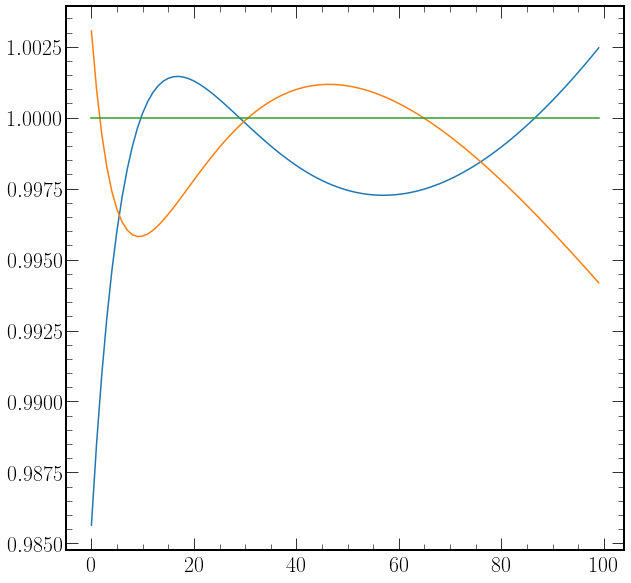

In [177]:
_ = plt.plot(y_down.T/pdictB['y_nom'])
_ = plt.plot(y_up.T/pdictB['y_nom'])
_ = plt.plot(pdictB['y_nom']/pdictB['y_nom'])